# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [6]:
# Import libraries

import math
import matplotlib.pyplot as plt
import time
import os

import jax
import jax.numpy as jnp
from jax import jacfwd

### Helper functions

In [7]:
# Function to read all vertices from input file
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))
    
    return jnp.array([x_arr, y_arr, theta_arr])

# Function to read all edges from input file
def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

# Function to draw the pose graph
def draw(X, Y, THETA, title):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'bo')
    plt.plot(X, Y, 'g-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'r->')
    
    plt.title(title)
    plt.show()
    
# Function to compute frobenius norm
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [8]:
# Function to model the motion of the robot
def motion_model(pose, control):
    x_k, y_k, theta_k = pose
    del_x, del_y, del_theta = control
    
    x_k1 = x_k + del_x * jnp.cos(theta_k) - del_y * jnp.sin(theta_k)
    y_k1 = y_k + del_y * jnp.cos(theta_k) + del_x * jnp.sin(theta_k)
    theta_k1 = theta_k + del_theta
    
    return jnp.array([x_k1, y_k1, theta_k1])

# Function to retrieve all poses from initial pose and edges
def get_poses(pose, edges):
    ind1_arr, ind2_arr, del_x, del_y, del_theta = edges
    ret_poses = [pose]
    
    for i in range(len(ind1_arr)):
        if ind2_arr[i] - ind1_arr[i] == 1:
            control = (del_x[i], del_y[i], del_theta[i])
            ret_poses.append(motion_model(ret_poses[-1], control))
        
    return jnp.array(ret_poses).T

# Function to write poses and control inputs to output file
def write_poses(all_poses, all_edges, path, fileName):
    write_str = ""
    for i, (x_p, y_p, theta_p) in enumerate(all_poses.T):
        write_str += "VERTEX_SE2 %d %.17f %.17f %.17f\n" % (i, x_p, y_p, theta_p)
    
    ind1_e, ind2_e, x_e, y_e, theta_e = all_edges
    for i in range(len(ind1_e)):
        if ind2_e[i] - ind1_e[i] == 1:
            write_str += "EDGE_SE2 %d %d %.17f %.17f %.17f %f %f %f %f %f %f\n" % (ind1_e[i], ind2_e[i], x_e[i], y_e[i], theta_e[i], 500, 0, 0, 500, 0, 500)
            
    write_str += "FIX 0\n"
    for i in range(len(ind1_e)):        
        if ind2_e[i] - ind1_e[i] != 1:
            write_str += "EDGE_SE2 %d %d %.17f %.17f %.17f %f %f %f %f %f %f\n" % (ind1_e[i], ind2_e[i], x_e[i], y_e[i], theta_e[i], 700, 0, 0, 700, 0, 700)
        
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    with open(os.path.join(path, fileName), 'w') as f:
        f.write(write_str)
        f.close()

In [9]:
# Read initial pose and all edges
init_pose = readVertex("../data/edges.txt")[:, 0]
edges = readEdge("../data/edges.txt")

# Retrieve all poses using edges and motion model and write into a file
all_poses = get_poses(init_pose, edges)
write_poses(all_poses, edges, "../data/", "edges-poses.g2o")

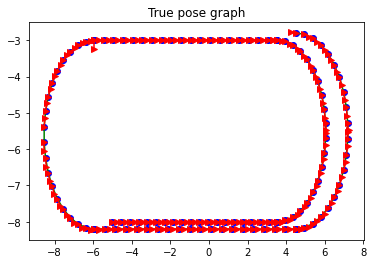

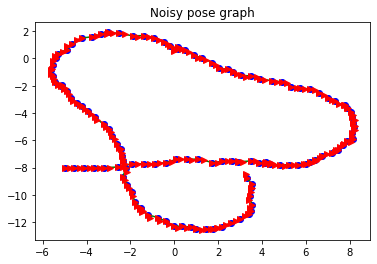

In [10]:
# Read vertices from ground truth pose graph and plot it
true_poses = readVertex("../data/gt.txt")
draw(true_poses[0, :], true_poses[1, :], true_poses[2, :], "True pose graph")

# Read vertices from noisy pose graph retrived using edges and plot it
noisy_poses = readVertex("../data/edges-poses.g2o")
draw(noisy_poses[0, :], noisy_poses[1, :], noisy_poses[2, :], "Noisy pose graph")

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [11]:
# Function to compute residual
def compute_residual(poses, edges):
    div = poses.shape[0] // 3
    ind1, ind2, del_x, del_y, del_theta = edges
    
    residual = jnp.zeros(3*(len(ind1)+1))
    for i in range(len(ind1)):
        pose_k = jnp.array([poses[ind1[i]], poses[ind1[i]+div], poses[ind1[i]+2*div]])
        pose_k1 = jnp.array([poses[ind2[i]], poses[ind2[i]+div], poses[ind2[i]+2*div]])
        control = jnp.array([del_x[i], del_y[i], del_theta[i]])
        
        residual = residual.at[3*i:3*i+3].set(motion_model(pose_k, control) - pose_k1)
    
    pose_k = jnp.array([poses[0], poses[div], poses[2*div]])
    residual = residual.at[3*len(ind1):3*len(ind1)+3].set(pose_k - jnp.array([-5, -8, 0]))
    
    return residual

# Function to compute Jacobian manually
def compute_jacobian(poses, edges):
    div = poses.shape[0] // 3
    x, y, theta = poses[:div], poses[div:2*div], poses[2*div:]
    ind1, ind2, del_x, del_y, del_theta = edges
    
    J = jnp.zeros((3*ind1.shape[0]+3, poses.shape[0]))
    for i in range(ind1.shape[0]):
        k, k1 = ind1[i], ind2[i]
        
        J = J.at[3*i, k].set(1)
        J = J.at[3*i, k1].set(-1)
        J = J.at[3*i, k + 2*div].set(-del_x[i] * jnp.sin(theta[k]) - del_y[i] * jnp.cos(theta[k]))
        
        J = J.at[3*i+1, k + div].set(1)
        J = J.at[3*i+1, k1 + div].set(-1)
        J = J.at[3*i+1, k + 2*div].set(-del_y[i] * jnp.sin(theta[k]) + del_x[i] * jnp.cos(theta[k]))
        
        J = J.at[3*i+2, k + 2*div].set(1)
        J = J.at[3*i+2, k1 + 2*div].set(-1)
    
    J = J.at[3*ind1.shape[0], 0].set(1)
    J = J.at[3*ind1.shape[0]+1, div].set(1)
    J = J.at[3*ind1.shape[0]+2, 2*div].set(1)
    
    return J


# Function to compute information matrix
def compute_info_mat(edges, info_edge, info_closure, info_fixed):
    (ind1, ind2, _, _, _) = edges
    size = 3 * (len(ind1) + 1)
    info_mat = jnp.identity(size)
    
    for i in range(len(ind1)):
        if ind1[i] + 1 == ind2[i]:
            for j in range(3):
                info_mat = info_mat.at[3*i+j, 3*i+j].set(info_edge)
        else:
            for j in range(3):
                info_mat = info_mat.at[3*i+j, 3*i+j].set(info_closure)
    
    for j in range(3):
        info_mat = info_mat.at[3*len(ind1)+j, 3*len(ind1)+j].set(info_fixed)
                
    return info_mat

In [17]:
# Function for SLAM 2D
def SLAM_2D(x_in, u_in, info_mat, max_iters, lam, thresh):
    x_in = x_in.reshape(-1)
    
    # Jacobian using jacfwd
    f = lambda a: compute_residual(a, u_in)
    J = jacfwd(f)
    
    x = x_in
    for i in range(max_iters):
        # Draw plots for every 5 iterations
        if i % 5 == 0:
            div = x.shape[0] // 3
            draw(true_poses[0, :], true_poses[1, :], true_poses[2, :], "True pose graph")
            draw(x_in[:div], x_in[div:2*div], x_in[2*div:], "Noisy pose graph")
            if i != 0:
                draw(x[:div], x[div:2*div], x[2*div:], "Optimised pose graph after iteration %d" %(i))
            
        print("Iteration %d" % (i+1))
            
        # Jax computation of jacobian
        start = time.time()
        J_jax = J(x)
        end = time.time()
        print("Time taken by jax to compute jacobian: %.5f" % (end - start))
        
        # Analytical computation of jacobian
        start = time.time()
        J_man = compute_jacobian(x, u_in)
        end = time.time()
        print("Time taken to compute jacobian analytically: %.5f" % (end - start))
        
        # Frobenius norm between jacobians computeda above
        frobNorm(J_jax, J_man, "jax jacobian", "analytical jacobian")
        
        # LM  step computation
        H = J_man.T @ info_mat @ J_man
        H = H + lam * jnp.identity(H.shape[0])
        b = J_man.T @ info_mat.T @ f(x)
        
        dx = -jnp.linalg.inv(H) @ b
        x_tmp = x + dx
        
        # Cost/ error value
        prev_cost = (f(x).T @ info_mat @ f(x))/2
        curr_cost = (f(x_tmp).T @ info_mat @ f(x_tmp))/2
        print("Error: %.5f\n" % (prev_cost))
        
        # Convergence check (L2 norm)
        if jnp.linalg.norm(x_tmp - x) < thresh:
            print("SLAM converged at iteration", i+1)
            break
            
        if curr_cost < prev_cost:
            lam = lam / 10
            x = x_tmp
        else:
            lam = lam * 10
       
    div = x.shape[0] // 3
    draw(true_poses[0, :], true_poses[1, :], true_poses[2, :], "True pose graph")
    draw(x_in[:div], x_in[div:2*div], x_in[2*div:], "Noisy pose graph")
    draw(x[:div], x[div:2*div], x[2*div:], "Final optimised pose graph")

    return x.reshape(3, -1)

#### Information values (500, 700, 1000)

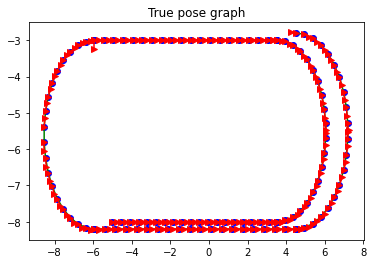

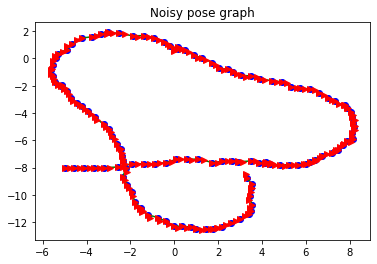

Iteration 1
Time taken by jax to compute jacobian: 3.38271
Time taken to compute jacobian analytically: 2.66520
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 639372.00000

Iteration 2
Time taken by jax to compute jacobian: 3.50421
Time taken to compute jacobian analytically: 2.45915
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 90906.54688

Iteration 3
Time taken by jax to compute jacobian: 3.24078
Time taken to compute jacobian analytically: 2.49131
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 18668.32031

Iteration 4
Time taken by jax to compute jacobian: 3.24229
Time taken to compute jacobian analytically: 2.47232
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 2415.35938

Iteration 5
Time taken by jax to compute jacobian: 3.22900
Time taken to compute jacobian analytically: 2.46853
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 2415.35938



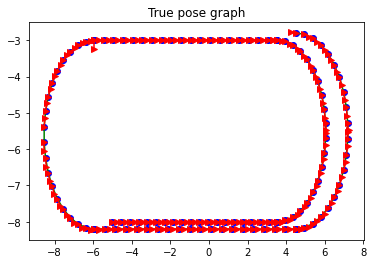

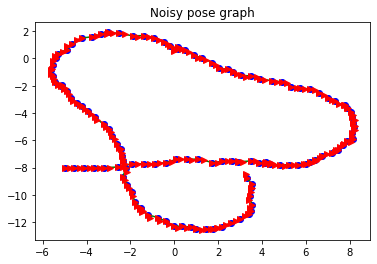

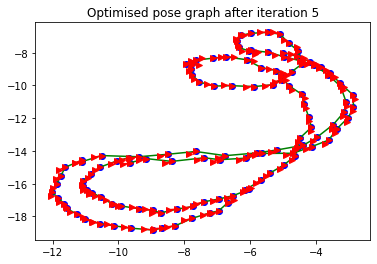

Iteration 6
Time taken by jax to compute jacobian: 3.20027
Time taken to compute jacobian analytically: 2.43559
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 2415.35938

Iteration 7
Time taken by jax to compute jacobian: 3.29652
Time taken to compute jacobian analytically: 2.47056
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 2415.35938

Iteration 8
Time taken by jax to compute jacobian: 3.23112
Time taken to compute jacobian analytically: 2.44030
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 2415.35938

Iteration 9
Time taken by jax to compute jacobian: 3.20811
Time taken to compute jacobian analytically: 2.43797
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 1157.91602

Iteration 10
Time taken by jax to compute jacobian: 3.24272
Time taken to compute jacobian analytically: 2.46381
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 1157.91602



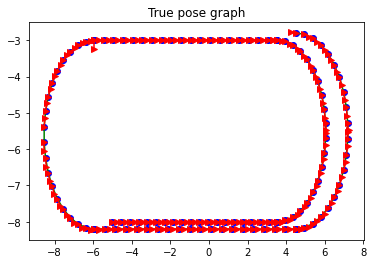

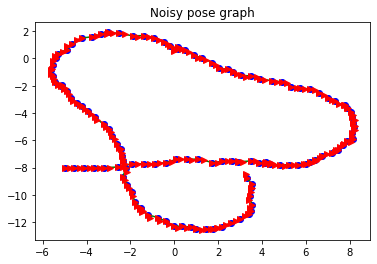

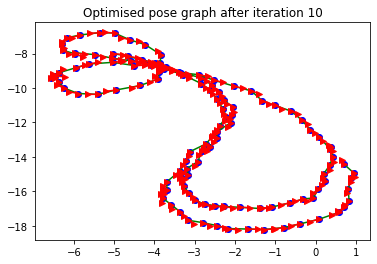

Iteration 11
Time taken by jax to compute jacobian: 3.23971
Time taken to compute jacobian analytically: 2.46469
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 777.26849

Iteration 12
Time taken by jax to compute jacobian: 3.25071
Time taken to compute jacobian analytically: 2.48541
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 777.26849

Iteration 13
Time taken by jax to compute jacobian: 3.23238
Time taken to compute jacobian analytically: 2.47257
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 717.33319

Iteration 14
Time taken by jax to compute jacobian: 3.24674
Time taken to compute jacobian analytically: 2.46827
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 717.33319

Iteration 15
Time taken by jax to compute jacobian: 3.24939
Time taken to compute jacobian analytically: 2.48134
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 639.44714



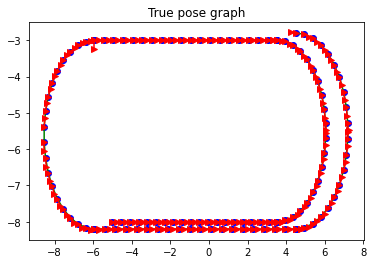

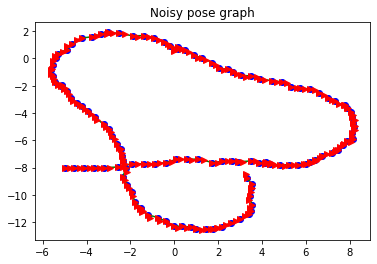

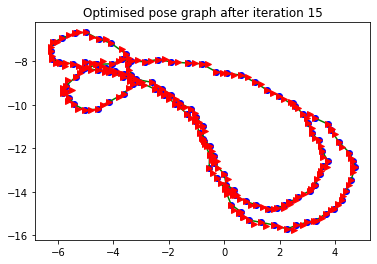

Iteration 16
Time taken by jax to compute jacobian: 3.21281
Time taken to compute jacobian analytically: 2.45979
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 639.44714

Iteration 17
Time taken by jax to compute jacobian: 3.20178
Time taken to compute jacobian analytically: 2.43074
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 589.51318

Iteration 18
Time taken by jax to compute jacobian: 3.21584
Time taken to compute jacobian analytically: 2.44431
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 589.51318

Iteration 19
Time taken by jax to compute jacobian: 3.20804
Time taken to compute jacobian analytically: 2.42366
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 550.38843

Iteration 20
Time taken by jax to compute jacobian: 3.25926
Time taken to compute jacobian analytically: 2.44068
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 550.38843



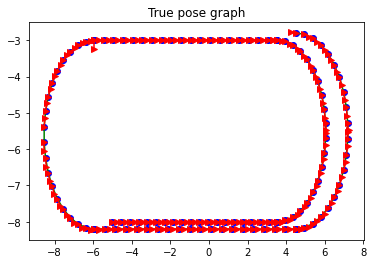

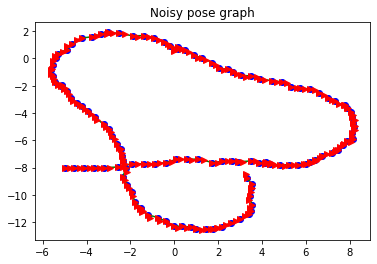

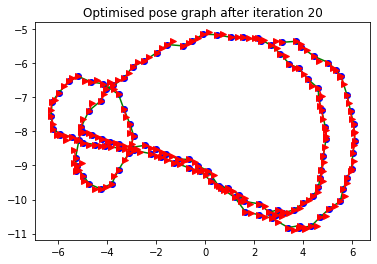

Iteration 21
Time taken by jax to compute jacobian: 3.32487
Time taken to compute jacobian analytically: 2.54896
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 521.55646

Iteration 22
Time taken by jax to compute jacobian: 3.22275
Time taken to compute jacobian analytically: 2.42527
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 521.55646

Iteration 23
Time taken by jax to compute jacobian: 3.19469
Time taken to compute jacobian analytically: 2.45292
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 500.22549

Iteration 24
Time taken by jax to compute jacobian: 3.26751
Time taken to compute jacobian analytically: 2.46543
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 500.22549

Iteration 25
Time taken by jax to compute jacobian: 3.21147
Time taken to compute jacobian analytically: 2.45574
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 484.61008



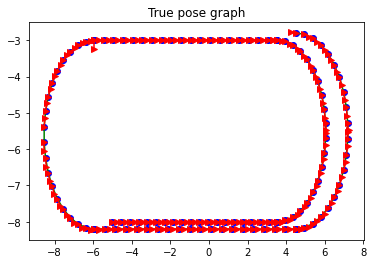

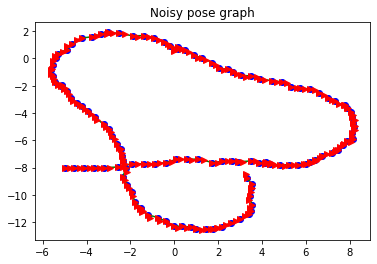

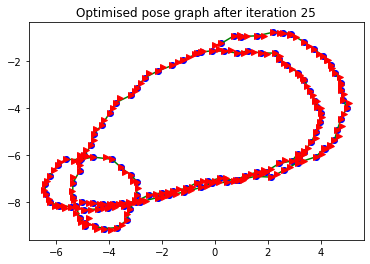

Iteration 26
Time taken by jax to compute jacobian: 3.21421
Time taken to compute jacobian analytically: 2.45068
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 483.53540

Iteration 27
Time taken by jax to compute jacobian: 3.24091
Time taken to compute jacobian analytically: 2.47666
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 454.78378

Iteration 28
Time taken by jax to compute jacobian: 3.22323
Time taken to compute jacobian analytically: 2.48037
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 448.15570

Iteration 29
Time taken by jax to compute jacobian: 3.21267
Time taken to compute jacobian analytically: 2.44272
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 445.86996

Iteration 30
Time taken by jax to compute jacobian: 3.24171
Time taken to compute jacobian analytically: 2.46582
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 445.08118



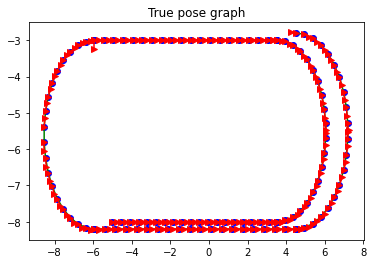

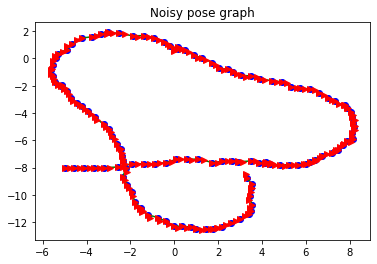

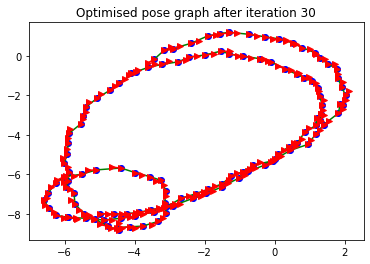

Iteration 31
Time taken by jax to compute jacobian: 3.25269
Time taken to compute jacobian analytically: 2.43360
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.77988

Iteration 32
Time taken by jax to compute jacobian: 3.24616
Time taken to compute jacobian analytically: 2.49324
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.65970

Iteration 33
Time taken by jax to compute jacobian: 3.23338
Time taken to compute jacobian analytically: 2.45986
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.61099

Iteration 34
Time taken by jax to compute jacobian: 3.23168
Time taken to compute jacobian analytically: 2.45268
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.59079

Iteration 35
Time taken by jax to compute jacobian: 3.24527
Time taken to compute jacobian analytically: 2.44812
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.58249



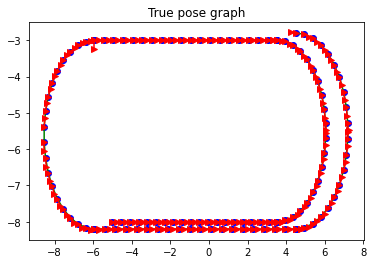

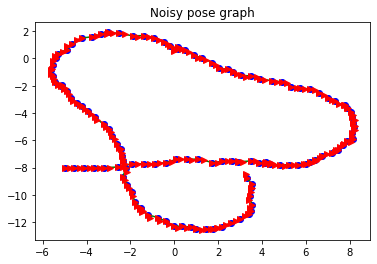

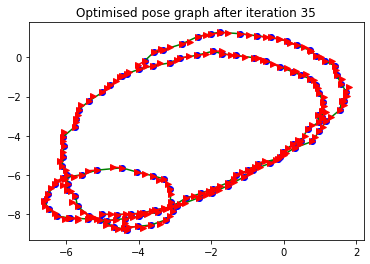

Iteration 36
Time taken by jax to compute jacobian: 3.23793
Time taken to compute jacobian analytically: 2.45650
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57840

Iteration 37
Time taken by jax to compute jacobian: 3.26358
Time taken to compute jacobian analytically: 2.50072
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57739

Iteration 38
Time taken by jax to compute jacobian: 3.22268
Time taken to compute jacobian analytically: 2.44826
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57715

Iteration 39
Time taken by jax to compute jacobian: 3.20525
Time taken to compute jacobian analytically: 2.43746
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57651

Iteration 40
Time taken by jax to compute jacobian: 3.19278
Time taken to compute jacobian analytically: 2.44156
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57623



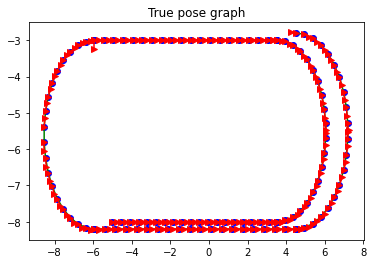

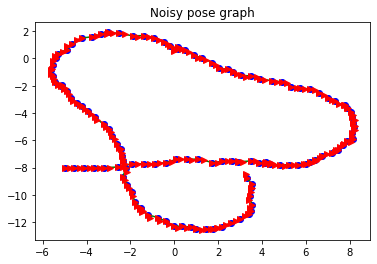

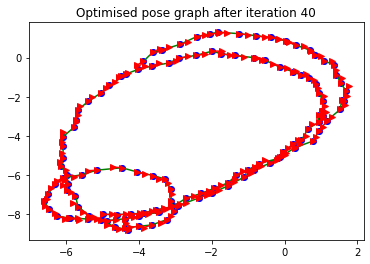

Iteration 41
Time taken by jax to compute jacobian: 3.28276
Time taken to compute jacobian analytically: 2.48412
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 42
Time taken by jax to compute jacobian: 3.23803
Time taken to compute jacobian analytically: 2.48423
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 43
Time taken by jax to compute jacobian: 3.23482
Time taken to compute jacobian analytically: 2.49611
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 44
Time taken by jax to compute jacobian: 3.23339
Time taken to compute jacobian analytically: 2.48616
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 45
Time taken by jax to compute jacobian: 3.19158
Time taken to compute jacobian analytically: 2.48904
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599



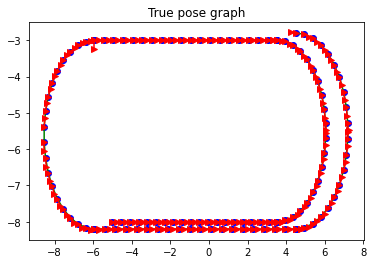

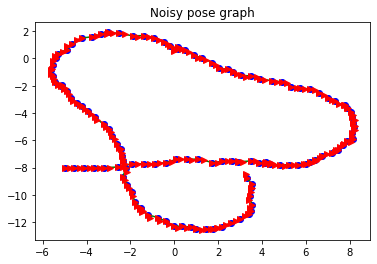

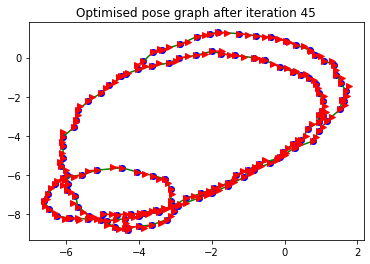

Iteration 46
Time taken by jax to compute jacobian: 3.20419
Time taken to compute jacobian analytically: 2.45399
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 47
Time taken by jax to compute jacobian: 3.20981
Time taken to compute jacobian analytically: 2.45893
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 48
Time taken by jax to compute jacobian: 3.19257
Time taken to compute jacobian analytically: 2.43469
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 49
Time taken by jax to compute jacobian: 3.29291
Time taken to compute jacobian analytically: 2.47592
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 50
Time taken by jax to compute jacobian: 3.23073
Time taken to compute jacobian analytically: 2.43732
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599



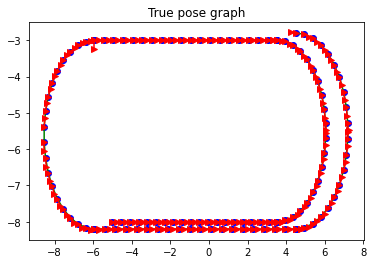

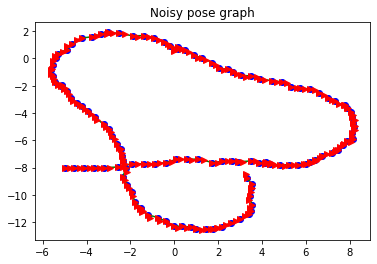

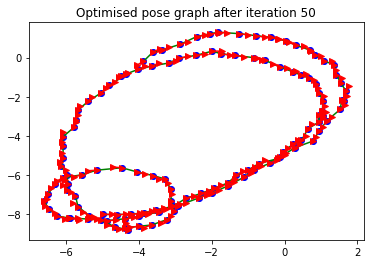

Iteration 51
Time taken by jax to compute jacobian: 3.20307
Time taken to compute jacobian analytically: 2.42407
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 52
Time taken by jax to compute jacobian: 3.19762
Time taken to compute jacobian analytically: 2.44610
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 53
Time taken by jax to compute jacobian: 3.20549
Time taken to compute jacobian analytically: 2.48347
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 54
Time taken by jax to compute jacobian: 3.23708
Time taken to compute jacobian analytically: 2.46381
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 55
Time taken by jax to compute jacobian: 3.22898
Time taken to compute jacobian analytically: 2.46128
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599



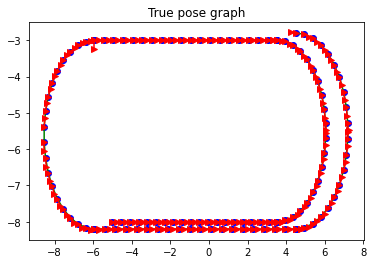

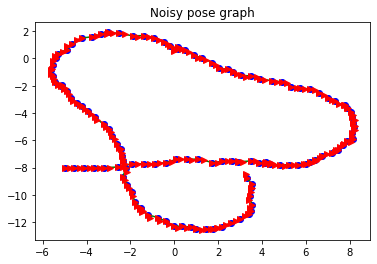

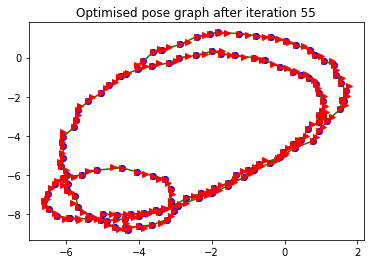

Iteration 56
Time taken by jax to compute jacobian: 3.23179
Time taken to compute jacobian analytically: 2.43915
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 57
Time taken by jax to compute jacobian: 3.25528
Time taken to compute jacobian analytically: 2.60697
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 58
Time taken by jax to compute jacobian: 3.24528
Time taken to compute jacobian analytically: 2.47238
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 59
Time taken by jax to compute jacobian: 3.25034
Time taken to compute jacobian analytically: 2.46644
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

Iteration 60
Time taken by jax to compute jacobian: 3.25673
Time taken to compute jacobian analytically: 2.50593
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 444.57599

SLAM 

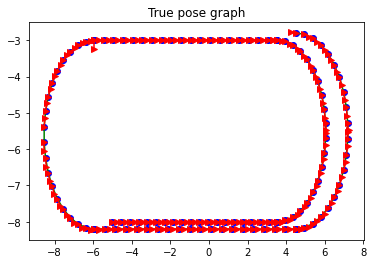

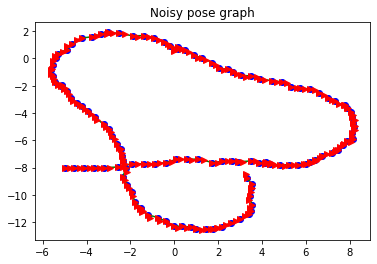

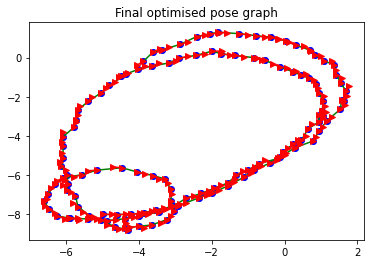

In [18]:
noisy_poses = readVertex("../data/edges-poses.g2o")
edges = readEdge("../data/edges-poses.g2o")
info_mat = compute_info_mat(edges, 500, 700, 1000)
opt_poses = SLAM_2D(noisy_poses, edges, info_mat, 200, 0.01, 1e-3)

write_poses(opt_poses, edges, "../data/500,700,1000", "opt-edges-poses.g2o")

#### Information values (250, 500, 1000)

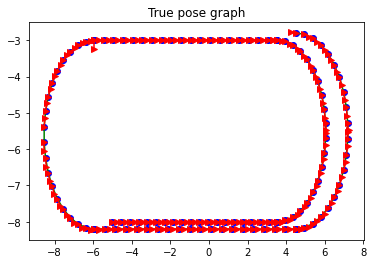

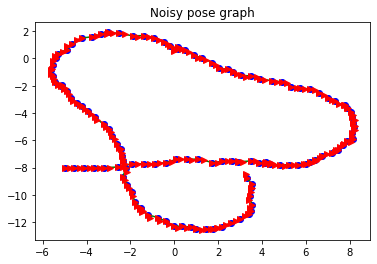

Iteration 1
Time taken by jax to compute jacobian: 3.19874
Time taken to compute jacobian analytically: 2.43468
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 456694.37500

Iteration 2
Time taken by jax to compute jacobian: 3.23993
Time taken to compute jacobian analytically: 2.49693
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 53279.08984

Iteration 3
Time taken by jax to compute jacobian: 3.22262
Time taken to compute jacobian analytically: 2.46328
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9443.08496

Iteration 4
Time taken by jax to compute jacobian: 3.22620
Time taken to compute jacobian analytically: 2.47027
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 1287.85535

Iteration 5
Time taken by jax to compute jacobian: 3.23664
Time taken to compute jacobian analytically: 2.62632
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 1287.85535



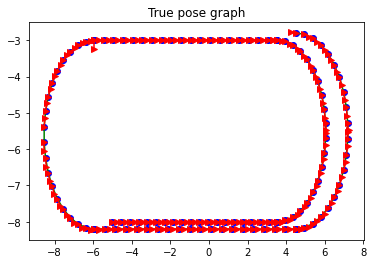

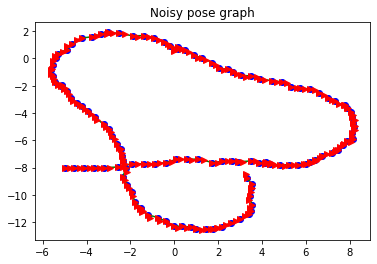

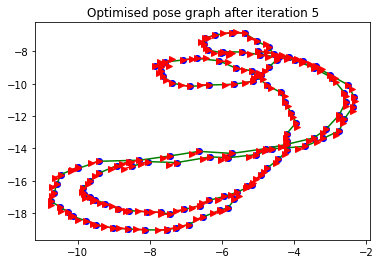

Iteration 6
Time taken by jax to compute jacobian: 3.40678
Time taken to compute jacobian analytically: 2.47550
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 1287.85535

Iteration 7
Time taken by jax to compute jacobian: 3.27965
Time taken to compute jacobian analytically: 2.49224
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 1287.85535

Iteration 8
Time taken by jax to compute jacobian: 3.28113
Time taken to compute jacobian analytically: 2.48970
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 1287.85535

Iteration 9
Time taken by jax to compute jacobian: 3.26338
Time taken to compute jacobian analytically: 2.48600
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 455.55096

Iteration 10
Time taken by jax to compute jacobian: 3.22936
Time taken to compute jacobian analytically: 2.50086
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 455.55096



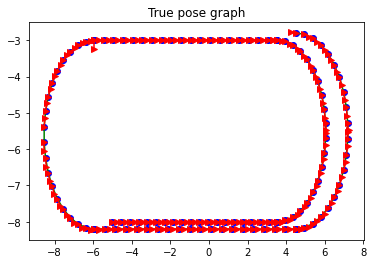

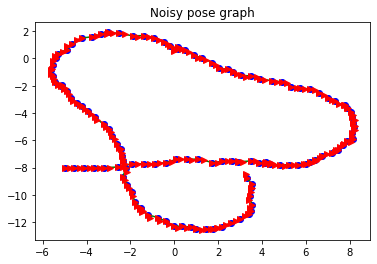

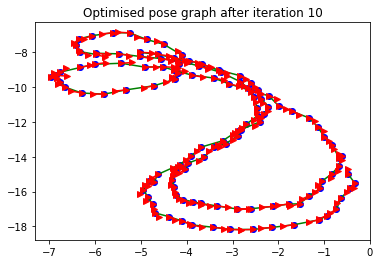

Iteration 11
Time taken by jax to compute jacobian: 3.21992
Time taken to compute jacobian analytically: 2.44711
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 408.65280

Iteration 12
Time taken by jax to compute jacobian: 3.21988
Time taken to compute jacobian analytically: 2.46838
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 408.65280

Iteration 13
Time taken by jax to compute jacobian: 3.21860
Time taken to compute jacobian analytically: 2.45535
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 380.91772

Iteration 14
Time taken by jax to compute jacobian: 3.22327
Time taken to compute jacobian analytically: 2.47131
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 380.91772

Iteration 15
Time taken by jax to compute jacobian: 3.23878
Time taken to compute jacobian analytically: 2.44269
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 356.56308



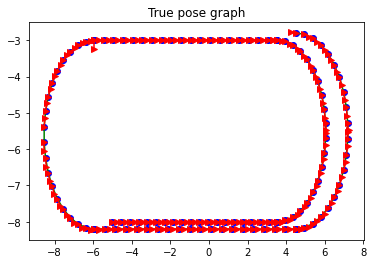

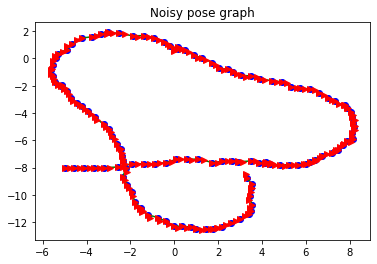

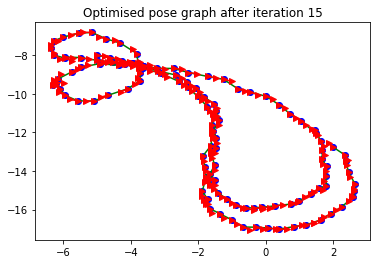

Iteration 16
Time taken by jax to compute jacobian: 3.27007
Time taken to compute jacobian analytically: 2.47851
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 356.56308

Iteration 17
Time taken by jax to compute jacobian: 3.24192
Time taken to compute jacobian analytically: 2.45471
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 335.52982

Iteration 18
Time taken by jax to compute jacobian: 3.23974
Time taken to compute jacobian analytically: 2.48093
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 335.52982

Iteration 19
Time taken by jax to compute jacobian: 3.22437
Time taken to compute jacobian analytically: 2.46026
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 317.42743

Iteration 20
Time taken by jax to compute jacobian: 3.19780
Time taken to compute jacobian analytically: 2.44450
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 317.42743



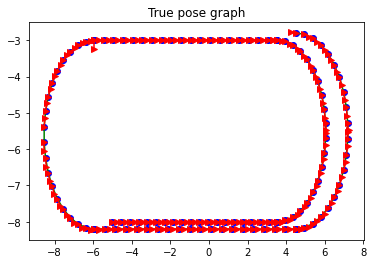

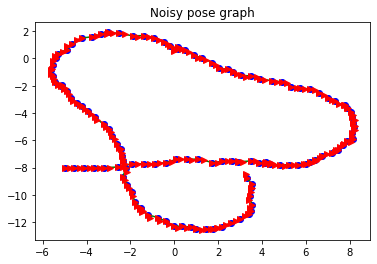

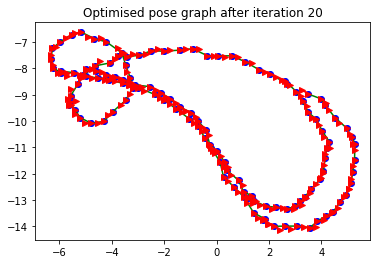

Iteration 21
Time taken by jax to compute jacobian: 3.21455
Time taken to compute jacobian analytically: 2.44808
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 302.02542

Iteration 22
Time taken by jax to compute jacobian: 3.24123
Time taken to compute jacobian analytically: 2.46146
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 302.02542

Iteration 23
Time taken by jax to compute jacobian: 3.25989
Time taken to compute jacobian analytically: 2.44255
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 288.99710

Iteration 24
Time taken by jax to compute jacobian: 3.27418
Time taken to compute jacobian analytically: 2.51909
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 288.99710

Iteration 25
Time taken by jax to compute jacobian: 3.95726
Time taken to compute jacobian analytically: 4.00407
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 278.02878



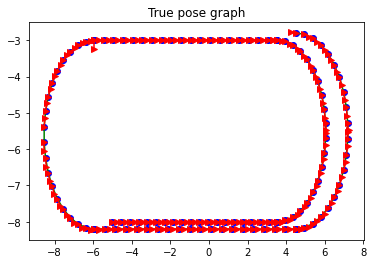

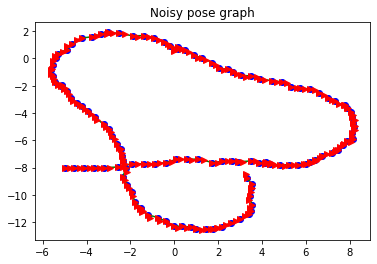

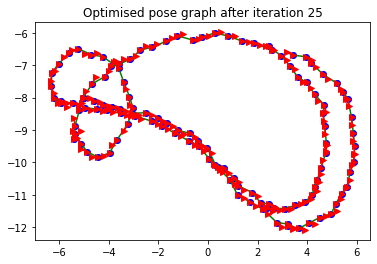

Iteration 26
Time taken by jax to compute jacobian: 3.83909
Time taken to compute jacobian analytically: 2.97630
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 278.02878

Iteration 27
Time taken by jax to compute jacobian: 3.27300
Time taken to compute jacobian analytically: 2.71138
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 268.83340

Iteration 28
Time taken by jax to compute jacobian: 3.39198
Time taken to compute jacobian analytically: 3.51634
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 268.83340

Iteration 29
Time taken by jax to compute jacobian: 3.27818
Time taken to compute jacobian analytically: 2.44685
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 261.16049

Iteration 30
Time taken by jax to compute jacobian: 3.45720
Time taken to compute jacobian analytically: 3.56247
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 261.16049



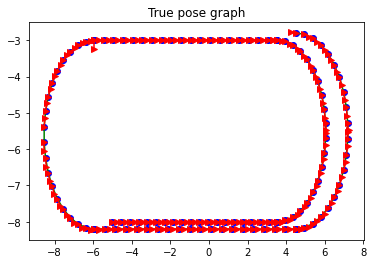

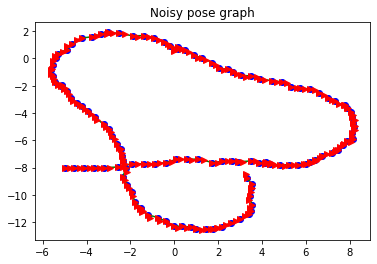

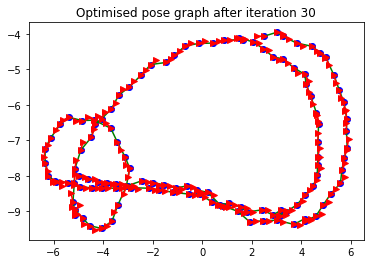

Iteration 31
Time taken by jax to compute jacobian: 3.37440
Time taken to compute jacobian analytically: 2.51186
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 254.78761

Iteration 32
Time taken by jax to compute jacobian: 4.56257
Time taken to compute jacobian analytically: 3.28612
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 254.78761

Iteration 33
Time taken by jax to compute jacobian: 3.26403
Time taken to compute jacobian analytically: 2.44990
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 249.51982

Iteration 34
Time taken by jax to compute jacobian: 3.33126
Time taken to compute jacobian analytically: 2.58986
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 248.32831

Iteration 35
Time taken by jax to compute jacobian: 3.33919
Time taken to compute jacobian analytically: 2.46789
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 234.38557



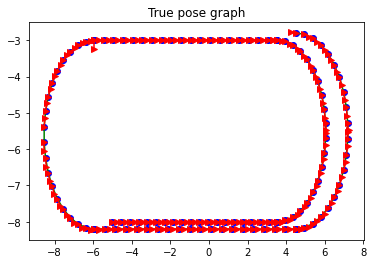

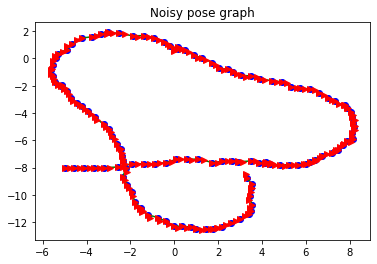

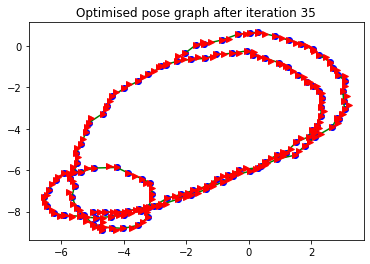

Iteration 36
Time taken by jax to compute jacobian: 3.48131
Time taken to compute jacobian analytically: 2.54350
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 229.03461

Iteration 37
Time taken by jax to compute jacobian: 3.25596
Time taken to compute jacobian analytically: 2.46588
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 227.47578

Iteration 38
Time taken by jax to compute jacobian: 3.50001
Time taken to compute jacobian analytically: 2.54523
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.94835

Iteration 39
Time taken by jax to compute jacobian: 3.57498
Time taken to compute jacobian analytically: 2.52850
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.75439

Iteration 40
Time taken by jax to compute jacobian: 3.26902
Time taken to compute jacobian analytically: 2.53474
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.67836



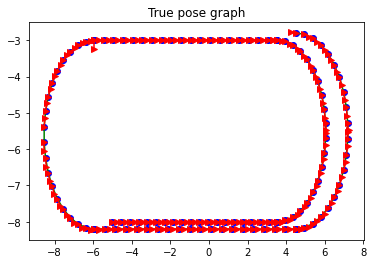

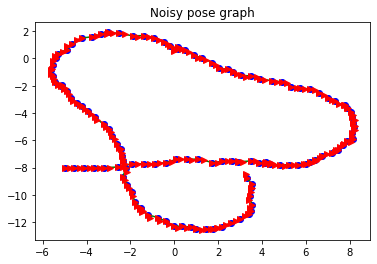

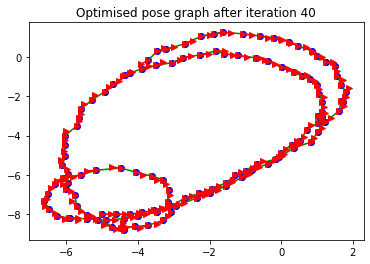

Iteration 41
Time taken by jax to compute jacobian: 3.37953
Time taken to compute jacobian analytically: 2.45587
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.64783

Iteration 42
Time taken by jax to compute jacobian: 3.26466
Time taken to compute jacobian analytically: 2.59140
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.63535

Iteration 43
Time taken by jax to compute jacobian: 3.24594
Time taken to compute jacobian analytically: 2.45953
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.63014

Iteration 44
Time taken by jax to compute jacobian: 3.23620
Time taken to compute jacobian analytically: 2.51744
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62805

Iteration 45
Time taken by jax to compute jacobian: 3.34901
Time taken to compute jacobian analytically: 2.50906
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62708



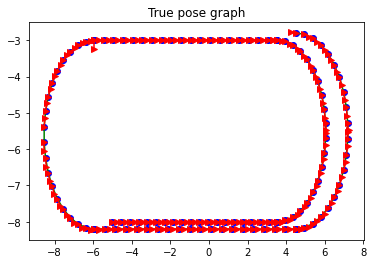

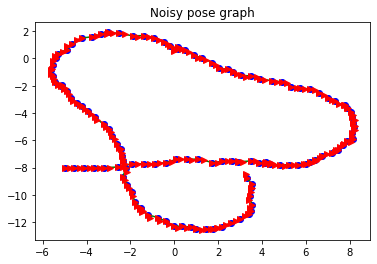

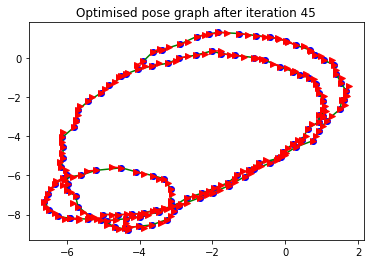

Iteration 46
Time taken by jax to compute jacobian: 3.24818
Time taken to compute jacobian analytically: 2.46621
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62666

Iteration 47
Time taken by jax to compute jacobian: 3.43850
Time taken to compute jacobian analytically: 3.12260
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 48
Time taken by jax to compute jacobian: 3.74258
Time taken to compute jacobian analytically: 2.56846
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 49
Time taken by jax to compute jacobian: 3.22740
Time taken to compute jacobian analytically: 2.50759
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 50
Time taken by jax to compute jacobian: 3.23383
Time taken to compute jacobian analytically: 2.50375
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657



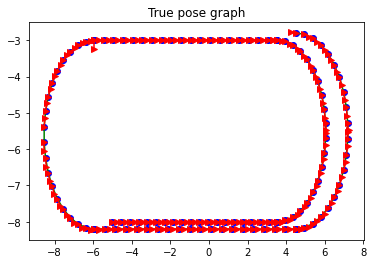

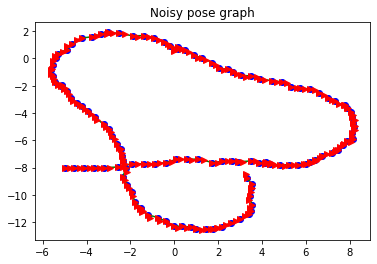

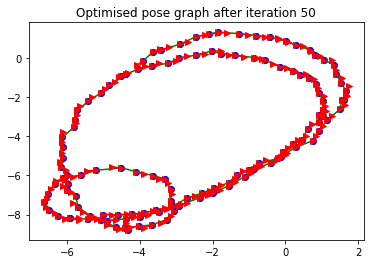

Iteration 51
Time taken by jax to compute jacobian: 3.27827
Time taken to compute jacobian analytically: 2.50160
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 52
Time taken by jax to compute jacobian: 3.29089
Time taken to compute jacobian analytically: 2.46818
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 53
Time taken by jax to compute jacobian: 3.24773
Time taken to compute jacobian analytically: 2.48361
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 54
Time taken by jax to compute jacobian: 3.32296
Time taken to compute jacobian analytically: 2.46374
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 55
Time taken by jax to compute jacobian: 3.20020
Time taken to compute jacobian analytically: 2.42933
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657



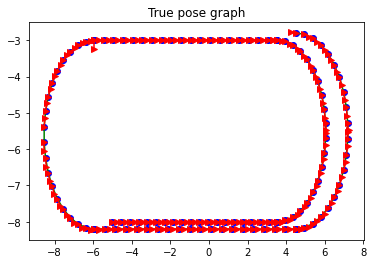

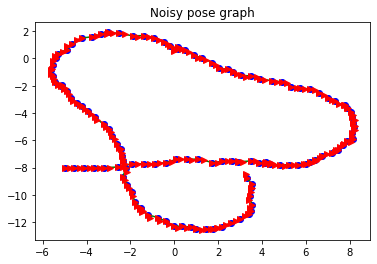

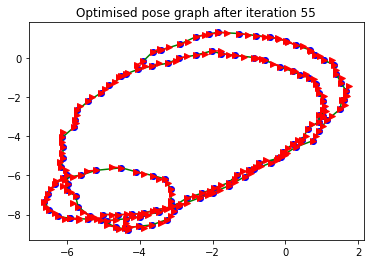

Iteration 56
Time taken by jax to compute jacobian: 3.39351
Time taken to compute jacobian analytically: 2.50140
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 57
Time taken by jax to compute jacobian: 3.26233
Time taken to compute jacobian analytically: 2.48555
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 58
Time taken by jax to compute jacobian: 3.20632
Time taken to compute jacobian analytically: 2.45964
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 59
Time taken by jax to compute jacobian: 3.19979
Time taken to compute jacobian analytically: 2.49856
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 60
Time taken by jax to compute jacobian: 3.17144
Time taken to compute jacobian analytically: 2.76145
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657



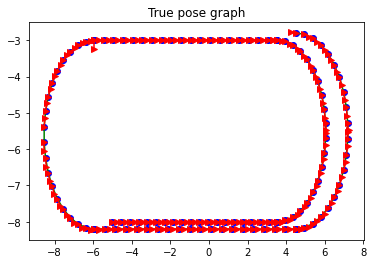

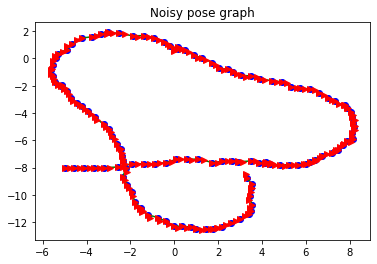

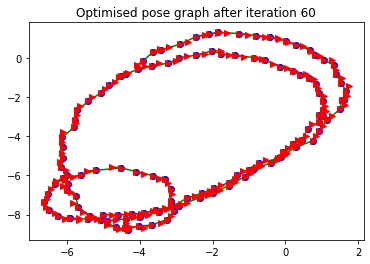

Iteration 61
Time taken by jax to compute jacobian: 3.22812
Time taken to compute jacobian analytically: 2.45302
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 62
Time taken by jax to compute jacobian: 3.43663
Time taken to compute jacobian analytically: 2.54870
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 63
Time taken by jax to compute jacobian: 3.27204
Time taken to compute jacobian analytically: 2.53340
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62657

Iteration 64
Time taken by jax to compute jacobian: 3.77530
Time taken to compute jacobian analytically: 2.44943
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62654

Iteration 65
Time taken by jax to compute jacobian: 4.21492
Time taken to compute jacobian analytically: 3.93316
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62654



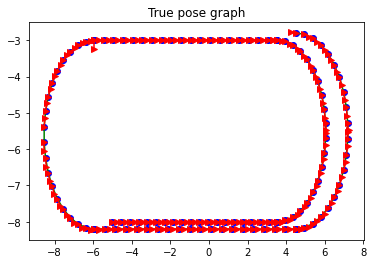

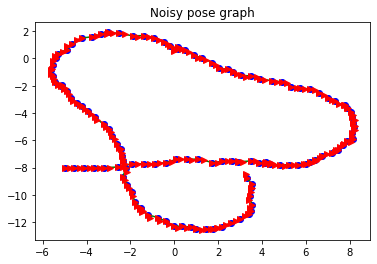

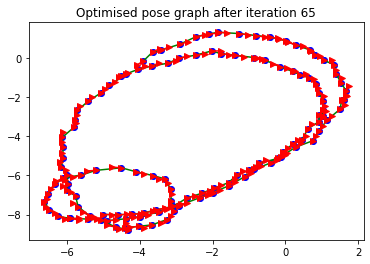

Iteration 66
Time taken by jax to compute jacobian: 3.55042
Time taken to compute jacobian analytically: 2.51397
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 226.62654

SLAM converged at iteration 66


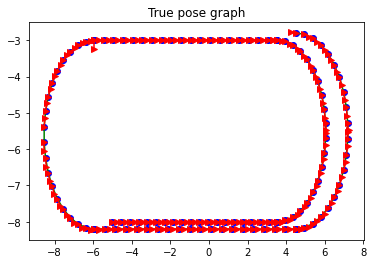

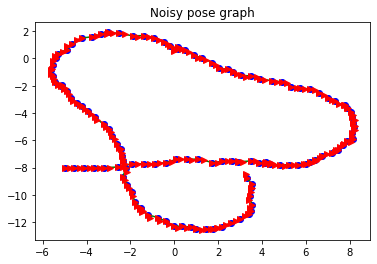

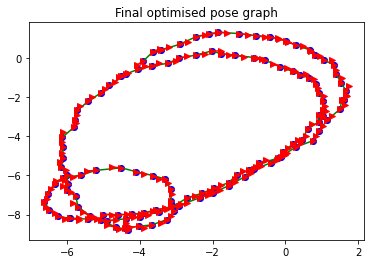

In [21]:
noisy_poses = readVertex("../data/edges-poses.g2o")
edges = readEdge("../data/edges-poses.g2o")
info_mat = compute_info_mat(edges, 250, 500, 1000)
opt_poses = SLAM_2D(noisy_poses, edges, info_mat, 200, 0.01, 1e-3)

write_poses(opt_poses, edges, "../data/250,500,1000", "opt-edges-poses.g2o")

#### Information values (50, 300, 1000)

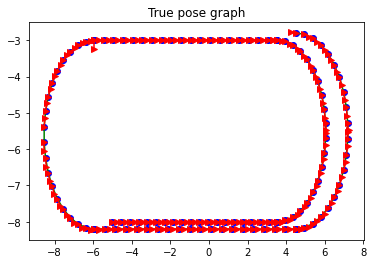

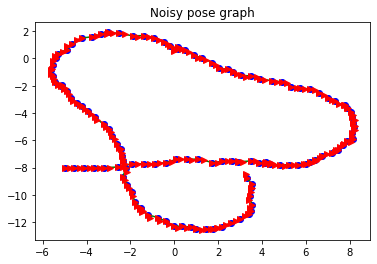

Iteration 1
Time taken by jax to compute jacobian: 3.85229
Time taken to compute jacobian analytically: 3.23341
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 274016.56250

Iteration 2
Time taken by jax to compute jacobian: 3.70045
Time taken to compute jacobian analytically: 3.08634
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 21560.66797

Iteration 3
Time taken by jax to compute jacobian: 3.67422
Time taken to compute jacobian analytically: 2.94634
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 2240.26904

Iteration 4
Time taken by jax to compute jacobian: 4.24535
Time taken to compute jacobian analytically: 3.05008
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 371.16071

Iteration 5
Time taken by jax to compute jacobian: 3.99999
Time taken to compute jacobian analytically: 3.06546
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 371.16071



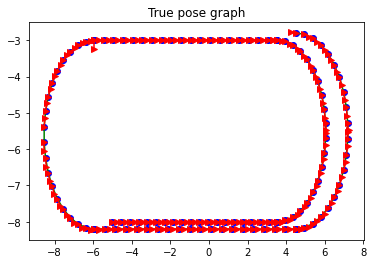

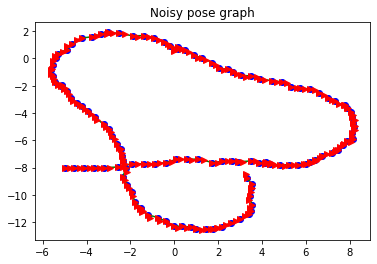

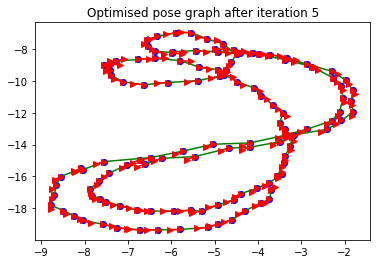

Iteration 6
Time taken by jax to compute jacobian: 3.56136
Time taken to compute jacobian analytically: 2.73740
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 371.16071

Iteration 7
Time taken by jax to compute jacobian: 3.58041
Time taken to compute jacobian analytically: 2.90347
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 371.16071

Iteration 8
Time taken by jax to compute jacobian: 3.66950
Time taken to compute jacobian analytically: 2.79263
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 97.94013

Iteration 9
Time taken by jax to compute jacobian: 3.54095
Time taken to compute jacobian analytically: 2.60571
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 97.94013

Iteration 10
Time taken by jax to compute jacobian: 3.86208
Time taken to compute jacobian analytically: 2.66844
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 87.76454



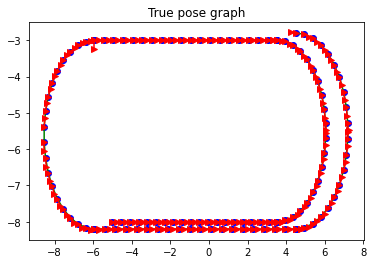

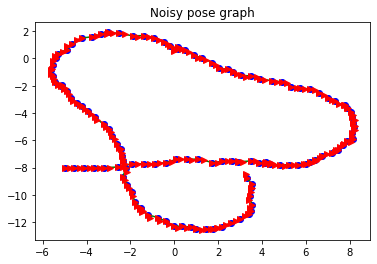

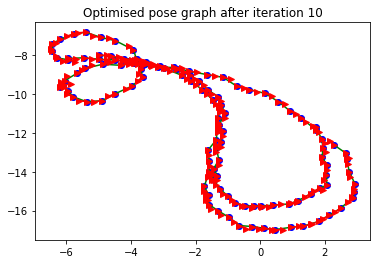

Iteration 11
Time taken by jax to compute jacobian: 3.88134
Time taken to compute jacobian analytically: 2.66747
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 87.76454

Iteration 12
Time taken by jax to compute jacobian: 3.65907
Time taken to compute jacobian analytically: 2.97186
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 77.11108

Iteration 13
Time taken by jax to compute jacobian: 4.06173
Time taken to compute jacobian analytically: 3.54428
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 77.11108

Iteration 14
Time taken by jax to compute jacobian: 3.40332
Time taken to compute jacobian analytically: 2.88628
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 68.04852

Iteration 15
Time taken by jax to compute jacobian: 3.66022
Time taken to compute jacobian analytically: 2.82751
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 68.04852



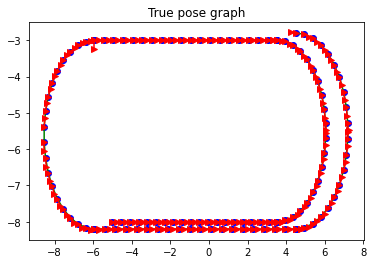

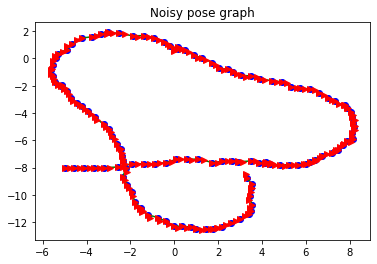

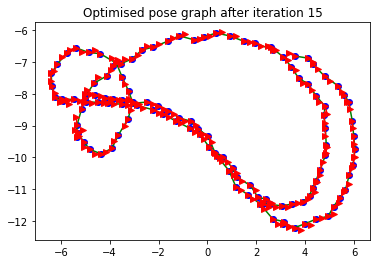

Iteration 16
Time taken by jax to compute jacobian: 3.68568
Time taken to compute jacobian analytically: 2.77828
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 61.73933

Iteration 17
Time taken by jax to compute jacobian: 3.47779
Time taken to compute jacobian analytically: 3.05436
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 61.73933

Iteration 18
Time taken by jax to compute jacobian: 3.50726
Time taken to compute jacobian analytically: 2.99663
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 57.19296

Iteration 19
Time taken by jax to compute jacobian: 3.67602
Time taken to compute jacobian analytically: 2.66550
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 57.19296

Iteration 20
Time taken by jax to compute jacobian: 4.00381
Time taken to compute jacobian analytically: 3.05725
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 54.07372



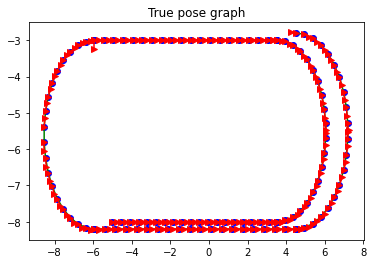

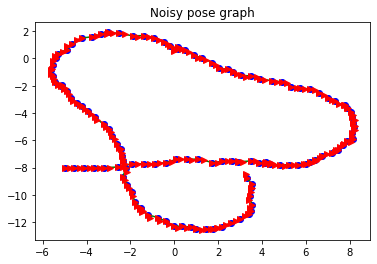

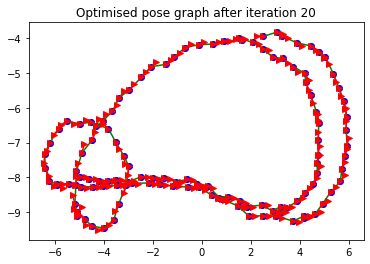

Iteration 21
Time taken by jax to compute jacobian: 4.66109
Time taken to compute jacobian analytically: 3.21291
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 54.07372

Iteration 22
Time taken by jax to compute jacobian: 3.69054
Time taken to compute jacobian analytically: 2.74403
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 51.91080

Iteration 23
Time taken by jax to compute jacobian: 3.77821
Time taken to compute jacobian analytically: 3.12949
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 51.91080

Iteration 24
Time taken by jax to compute jacobian: 3.48324
Time taken to compute jacobian analytically: 3.11863
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 50.41920

Iteration 25
Time taken by jax to compute jacobian: 3.75249
Time taken to compute jacobian analytically: 3.53951
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 50.41920



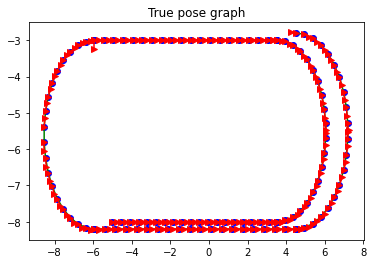

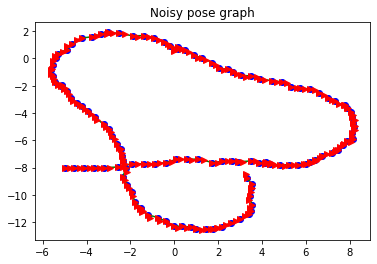

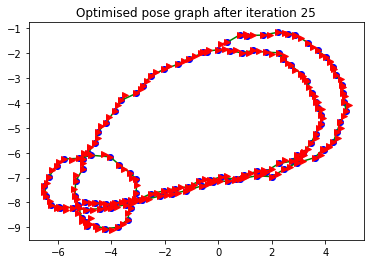

Iteration 26
Time taken by jax to compute jacobian: 4.20702
Time taken to compute jacobian analytically: 3.60174
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 49.38985

Iteration 27
Time taken by jax to compute jacobian: 3.60488
Time taken to compute jacobian analytically: 3.01579
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 49.31026

Iteration 28
Time taken by jax to compute jacobian: 3.77084
Time taken to compute jacobian analytically: 2.98715
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.72633

Iteration 29
Time taken by jax to compute jacobian: 3.87360
Time taken to compute jacobian analytically: 3.09682
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.34352

Iteration 30
Time taken by jax to compute jacobian: 3.22785
Time taken to compute jacobian analytically: 2.57229
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.21742



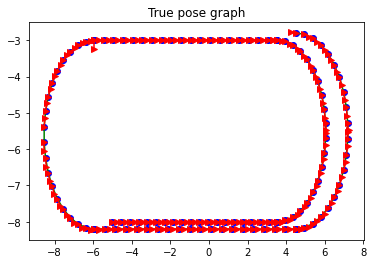

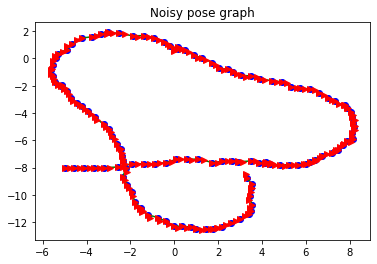

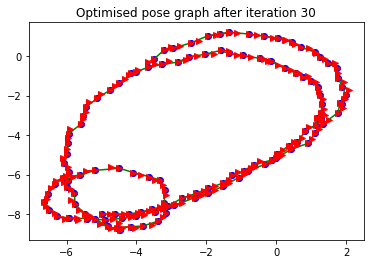

Iteration 31
Time taken by jax to compute jacobian: 3.48014
Time taken to compute jacobian analytically: 2.46438
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.17291

Iteration 32
Time taken by jax to compute jacobian: 3.24245
Time taken to compute jacobian analytically: 2.48666
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.15561

Iteration 33
Time taken by jax to compute jacobian: 3.20493
Time taken to compute jacobian analytically: 2.45931
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14860

Iteration 34
Time taken by jax to compute jacobian: 3.26707
Time taken to compute jacobian analytically: 2.46036
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14567

Iteration 35
Time taken by jax to compute jacobian: 3.24648
Time taken to compute jacobian analytically: 2.47453
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14440



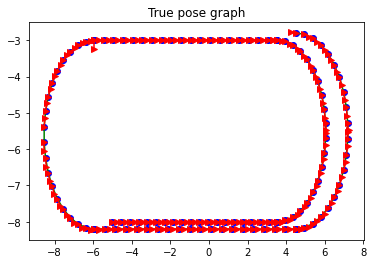

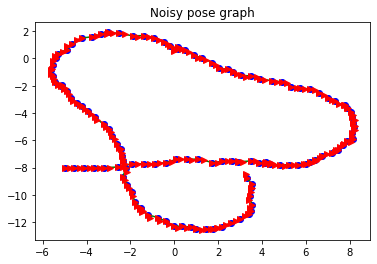

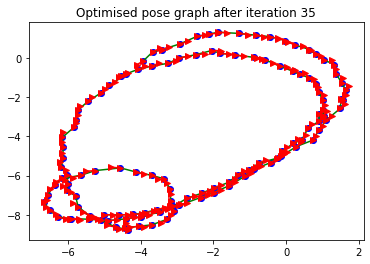

Iteration 36
Time taken by jax to compute jacobian: 3.32861
Time taken to compute jacobian analytically: 2.46166
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14390

Iteration 37
Time taken by jax to compute jacobian: 3.24570
Time taken to compute jacobian analytically: 2.46946
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14370

Iteration 38
Time taken by jax to compute jacobian: 3.35150
Time taken to compute jacobian analytically: 2.48312
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14361

Iteration 39
Time taken by jax to compute jacobian: 3.24508
Time taken to compute jacobian analytically: 2.47236
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14354

Iteration 40
Time taken by jax to compute jacobian: 3.29324
Time taken to compute jacobian analytically: 2.50216
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349



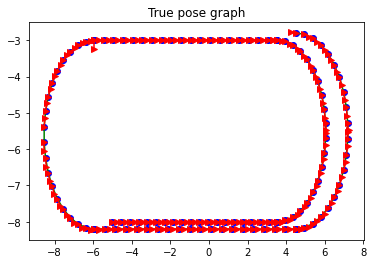

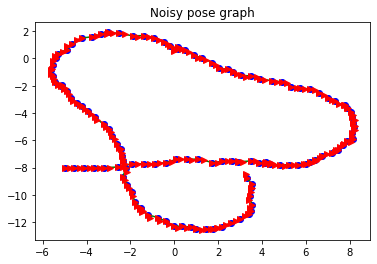

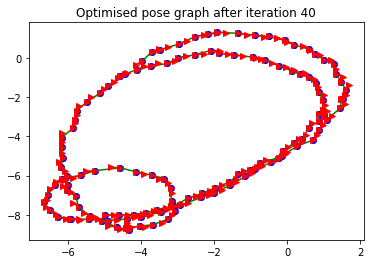

Iteration 41
Time taken by jax to compute jacobian: 3.23323
Time taken to compute jacobian analytically: 2.46858
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 42
Time taken by jax to compute jacobian: 3.46252
Time taken to compute jacobian analytically: 2.52728
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 43
Time taken by jax to compute jacobian: 3.61940
Time taken to compute jacobian analytically: 2.59500
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 44
Time taken by jax to compute jacobian: 3.24844
Time taken to compute jacobian analytically: 2.66458
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 45
Time taken by jax to compute jacobian: 3.42795
Time taken to compute jacobian analytically: 2.67748
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349



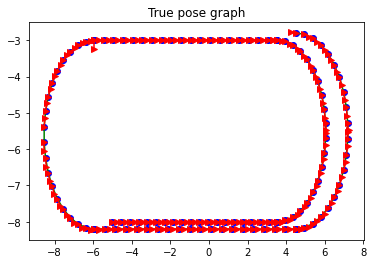

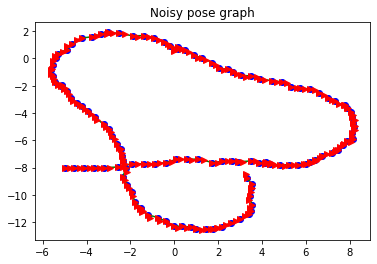

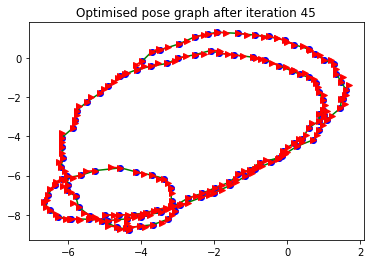

Iteration 46
Time taken by jax to compute jacobian: 3.45482
Time taken to compute jacobian analytically: 2.46502
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 47
Time taken by jax to compute jacobian: 3.25448
Time taken to compute jacobian analytically: 2.66090
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 48
Time taken by jax to compute jacobian: 3.35283
Time taken to compute jacobian analytically: 2.70359
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 49
Time taken by jax to compute jacobian: 3.21833
Time taken to compute jacobian analytically: 2.43589
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 50
Time taken by jax to compute jacobian: 3.23825
Time taken to compute jacobian analytically: 2.42684
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349



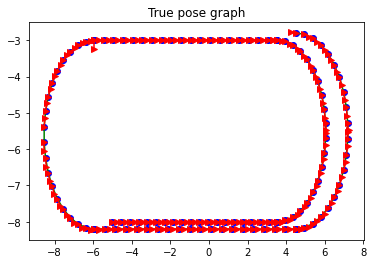

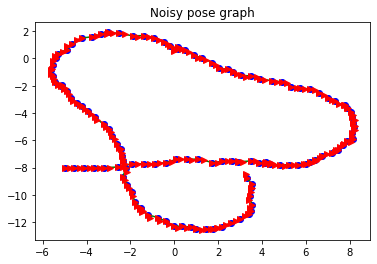

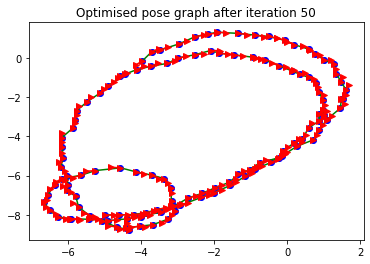

Iteration 51
Time taken by jax to compute jacobian: 3.20135
Time taken to compute jacobian analytically: 2.42996
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 52
Time taken by jax to compute jacobian: 3.20335
Time taken to compute jacobian analytically: 2.45314
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 53
Time taken by jax to compute jacobian: 3.21880
Time taken to compute jacobian analytically: 2.44212
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 54
Time taken by jax to compute jacobian: 3.21315
Time taken to compute jacobian analytically: 2.45032
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 55
Time taken by jax to compute jacobian: 3.22691
Time taken to compute jacobian analytically: 2.43816
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349



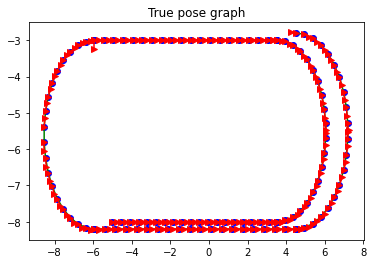

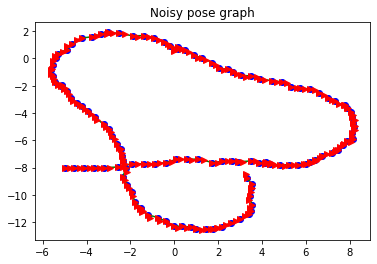

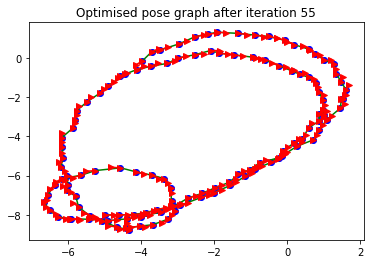

Iteration 56
Time taken by jax to compute jacobian: 3.32753
Time taken to compute jacobian analytically: 2.46372
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

Iteration 57
Time taken by jax to compute jacobian: 3.24177
Time taken to compute jacobian analytically: 3.20067
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 47.14349

SLAM converged at iteration 57


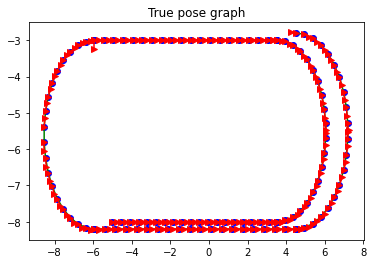

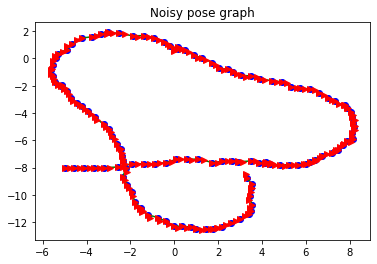

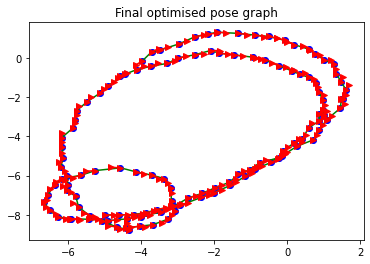

In [25]:
noisy_poses = readVertex("../data/edges-poses.g2o")
edges = readEdge("../data/edges-poses.g2o")
info_mat = compute_info_mat(edges, 50, 300, 1000)
opt_poses = SLAM_2D(noisy_poses, edges, info_mat, 200, 0.01, 1e-3)

write_poses(opt_poses, edges, "../data/50,300,1000", "opt-edges-poses.g2o")

#### Information values (50, 100, 1000)

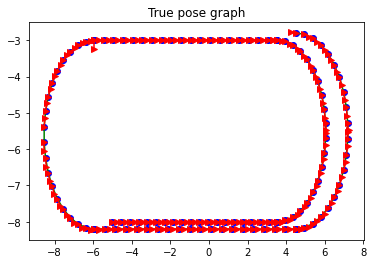

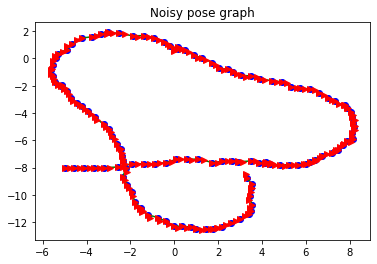

Iteration 1
Time taken by jax to compute jacobian: 3.66587
Time taken to compute jacobian analytically: 3.12785
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 91338.84375

Iteration 2
Time taken by jax to compute jacobian: 3.34313
Time taken to compute jacobian analytically: 2.51949
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 10794.20312

Iteration 3
Time taken by jax to compute jacobian: 3.19152
Time taken to compute jacobian analytically: 2.42488
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 1577.11987

Iteration 4
Time taken by jax to compute jacobian: 3.23101
Time taken to compute jacobian analytically: 2.61126
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 297.06143

Iteration 5
Time taken by jax to compute jacobian: 3.27679
Time taken to compute jacobian analytically: 2.47797
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 297.06143



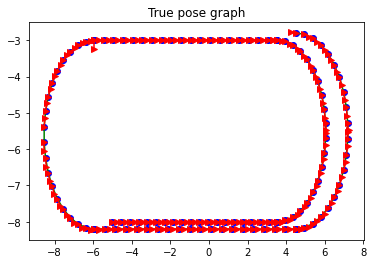

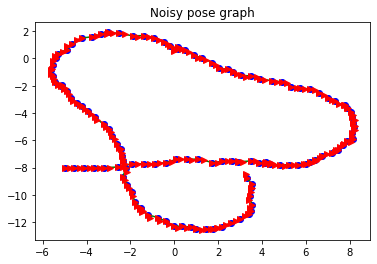

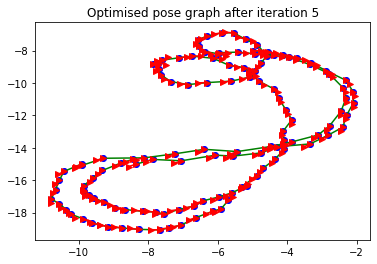

Iteration 6
Time taken by jax to compute jacobian: 3.27538
Time taken to compute jacobian analytically: 2.56836
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 297.06143

Iteration 7
Time taken by jax to compute jacobian: 3.25421
Time taken to compute jacobian analytically: 2.53775
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 297.06143

Iteration 8
Time taken by jax to compute jacobian: 3.30159
Time taken to compute jacobian analytically: 2.56068
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 114.97440

Iteration 9
Time taken by jax to compute jacobian: 3.32991
Time taken to compute jacobian analytically: 2.49681
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 114.97440

Iteration 10
Time taken by jax to compute jacobian: 3.44440
Time taken to compute jacobian analytically: 2.52629
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 79.78132



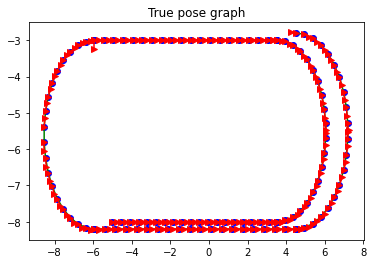

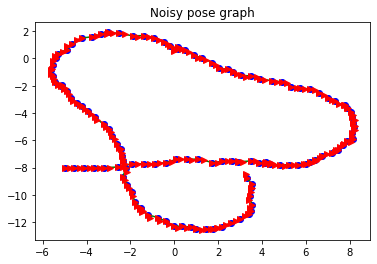

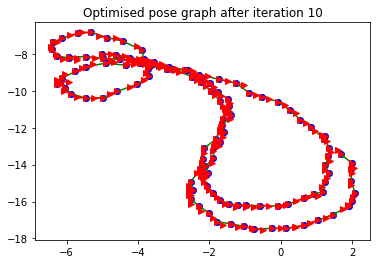

Iteration 11
Time taken by jax to compute jacobian: 3.25881
Time taken to compute jacobian analytically: 2.62667
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 79.78132

Iteration 12
Time taken by jax to compute jacobian: 3.24057
Time taken to compute jacobian analytically: 2.53348
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 73.42989

Iteration 13
Time taken by jax to compute jacobian: 3.35236
Time taken to compute jacobian analytically: 2.54717
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 73.42989

Iteration 14
Time taken by jax to compute jacobian: 3.24866
Time taken to compute jacobian analytically: 2.63306
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 64.63743

Iteration 15
Time taken by jax to compute jacobian: 3.67689
Time taken to compute jacobian analytically: 2.57933
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 64.63743



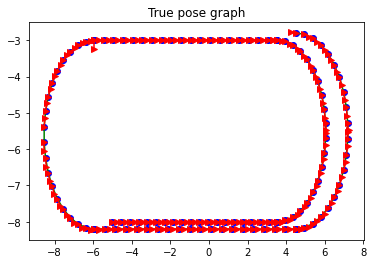

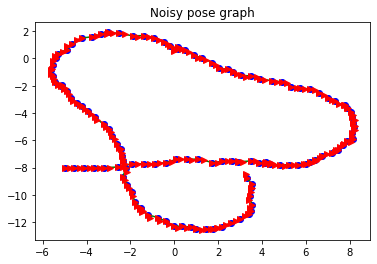

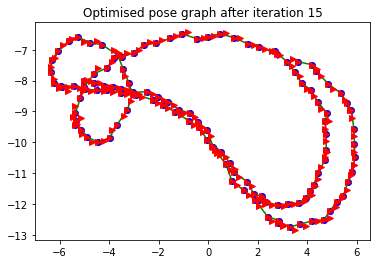

Iteration 16
Time taken by jax to compute jacobian: 3.35812
Time taken to compute jacobian analytically: 2.57609
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 59.30800

Iteration 17
Time taken by jax to compute jacobian: 3.28333
Time taken to compute jacobian analytically: 2.51483
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 59.30800

Iteration 18
Time taken by jax to compute jacobian: 3.28590
Time taken to compute jacobian analytically: 2.51035
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 55.16215

Iteration 19
Time taken by jax to compute jacobian: 3.25657
Time taken to compute jacobian analytically: 2.88670
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 55.16215

Iteration 20
Time taken by jax to compute jacobian: 3.38597
Time taken to compute jacobian analytically: 2.45479
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 52.23503



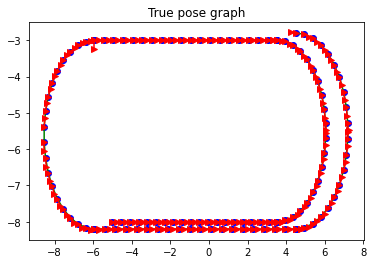

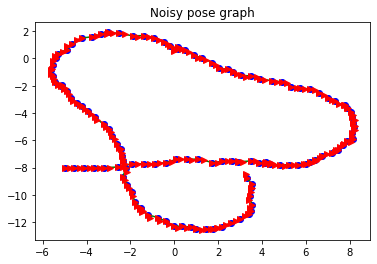

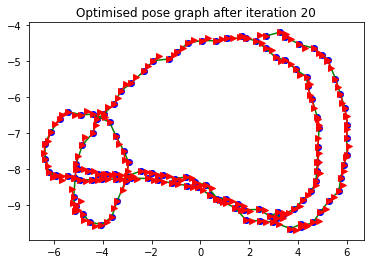

Iteration 21
Time taken by jax to compute jacobian: 3.29410
Time taken to compute jacobian analytically: 2.45746
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 52.23503

Iteration 22
Time taken by jax to compute jacobian: 3.56186
Time taken to compute jacobian analytically: 2.79216
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 50.13697

Iteration 23
Time taken by jax to compute jacobian: 3.21290
Time taken to compute jacobian analytically: 2.53224
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 50.13697

Iteration 24
Time taken by jax to compute jacobian: 4.67815
Time taken to compute jacobian analytically: 3.08598
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 48.65833

Iteration 25
Time taken by jax to compute jacobian: 3.62195
Time taken to compute jacobian analytically: 2.57490
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 48.33808



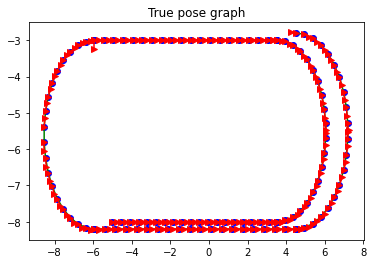

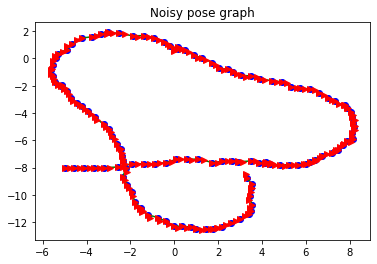

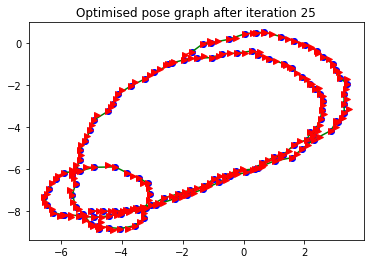

Iteration 26
Time taken by jax to compute jacobian: 3.26103
Time taken to compute jacobian analytically: 2.46788
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 46.08652

Iteration 27
Time taken by jax to compute jacobian: 3.59126
Time taken to compute jacobian analytically: 3.42059
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.58099

Iteration 28
Time taken by jax to compute jacobian: 3.77146
Time taken to compute jacobian analytically: 2.50079
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.41530

Iteration 29
Time taken by jax to compute jacobian: 3.53072
Time taken to compute jacobian analytically: 2.53156
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.35951

Iteration 30
Time taken by jax to compute jacobian: 3.43314
Time taken to compute jacobian analytically: 2.50146
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.33874



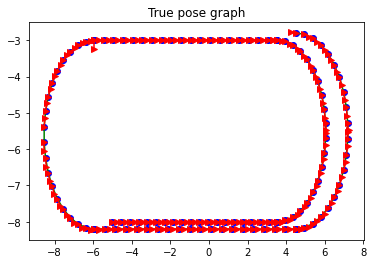

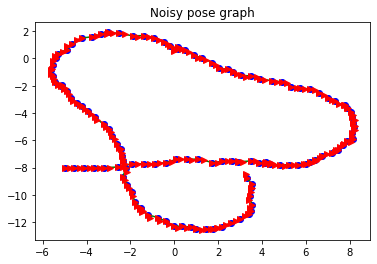

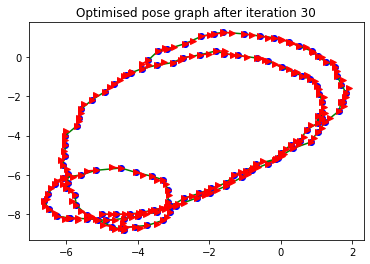

Iteration 31
Time taken by jax to compute jacobian: 3.24362
Time taken to compute jacobian analytically: 2.48671
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.33065

Iteration 32
Time taken by jax to compute jacobian: 3.28430
Time taken to compute jacobian analytically: 2.60939
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32745

Iteration 33
Time taken by jax to compute jacobian: 3.23704
Time taken to compute jacobian analytically: 2.46144
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32623

Iteration 34
Time taken by jax to compute jacobian: 3.26391
Time taken to compute jacobian analytically: 2.45411
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32567

Iteration 35
Time taken by jax to compute jacobian: 3.22475
Time taken to compute jacobian analytically: 2.46716
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32543



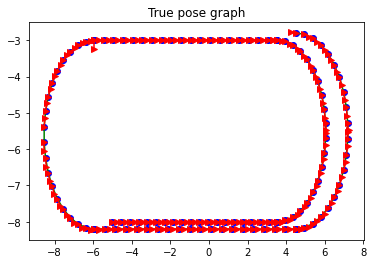

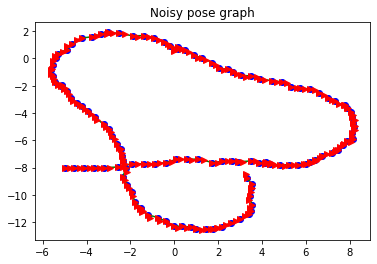

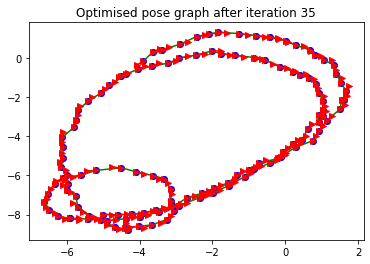

Iteration 36
Time taken by jax to compute jacobian: 3.21891
Time taken to compute jacobian analytically: 2.43710
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32536

Iteration 37
Time taken by jax to compute jacobian: 3.21754
Time taken to compute jacobian analytically: 2.49008
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32534

Iteration 38
Time taken by jax to compute jacobian: 3.17415
Time taken to compute jacobian analytically: 2.44391
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 39
Time taken by jax to compute jacobian: 3.18048
Time taken to compute jacobian analytically: 2.46627
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 40
Time taken by jax to compute jacobian: 3.17869
Time taken to compute jacobian analytically: 2.44625
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531



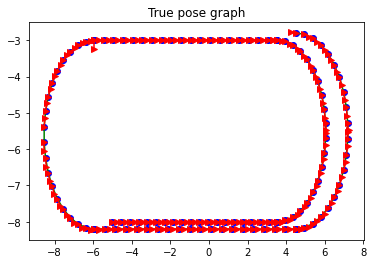

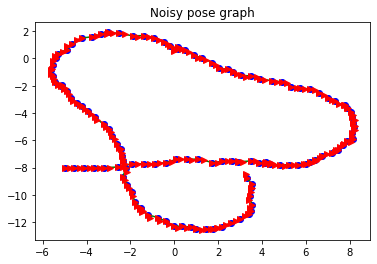

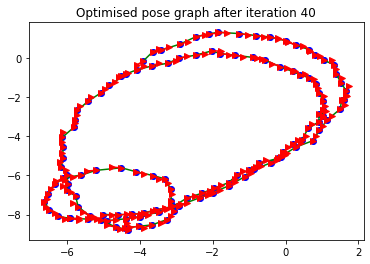

Iteration 41
Time taken by jax to compute jacobian: 3.18359
Time taken to compute jacobian analytically: 2.43794
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 42
Time taken by jax to compute jacobian: 3.20877
Time taken to compute jacobian analytically: 2.43480
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 43
Time taken by jax to compute jacobian: 3.17848
Time taken to compute jacobian analytically: 2.43813
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 44
Time taken by jax to compute jacobian: 3.17337
Time taken to compute jacobian analytically: 2.43347
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 45
Time taken by jax to compute jacobian: 3.27868
Time taken to compute jacobian analytically: 2.47439
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531



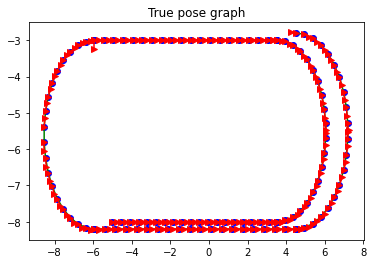

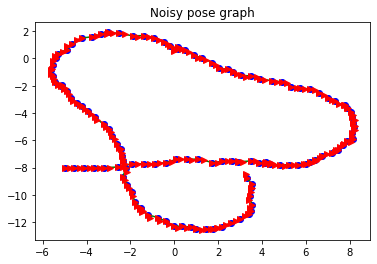

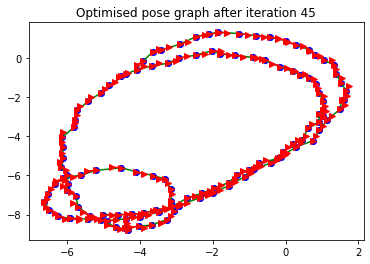

Iteration 46
Time taken by jax to compute jacobian: 3.40815
Time taken to compute jacobian analytically: 2.81323
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 47
Time taken by jax to compute jacobian: 3.43756
Time taken to compute jacobian analytically: 2.58565
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 48
Time taken by jax to compute jacobian: 3.57999
Time taken to compute jacobian analytically: 2.83172
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 49
Time taken by jax to compute jacobian: 3.76512
Time taken to compute jacobian analytically: 3.08345
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 50
Time taken by jax to compute jacobian: 3.38174
Time taken to compute jacobian analytically: 2.51665
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531



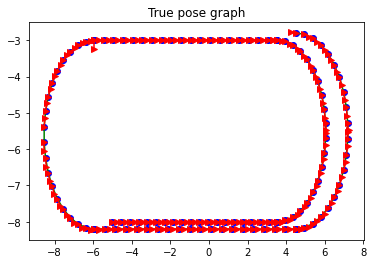

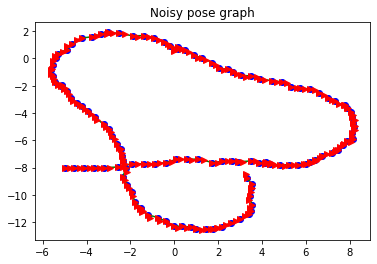

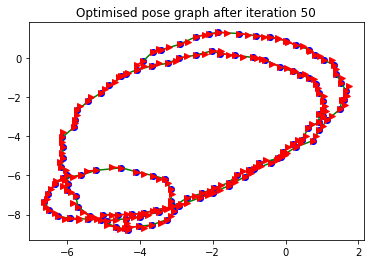

Iteration 51
Time taken by jax to compute jacobian: 3.65436
Time taken to compute jacobian analytically: 3.03971
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32531

Iteration 52
Time taken by jax to compute jacobian: 3.19661
Time taken to compute jacobian analytically: 2.45554
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32530

Iteration 53
Time taken by jax to compute jacobian: 3.23799
Time taken to compute jacobian analytically: 2.53351
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32530

Iteration 54
Time taken by jax to compute jacobian: 3.19427
Time taken to compute jacobian analytically: 2.46811
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32530

Iteration 55
Time taken by jax to compute jacobian: 3.21173
Time taken to compute jacobian analytically: 2.46159
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32530



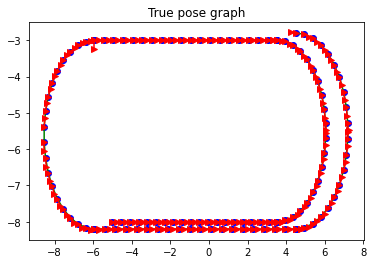

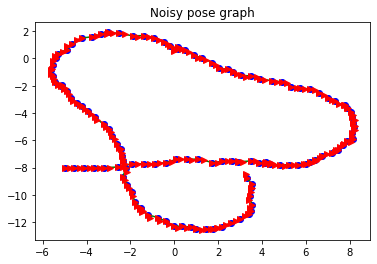

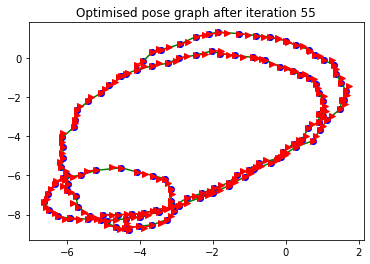

Iteration 56
Time taken by jax to compute jacobian: 3.21133
Time taken to compute jacobian analytically: 2.42751
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32530

Iteration 57
Time taken by jax to compute jacobian: 3.61036
Time taken to compute jacobian analytically: 2.45313
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 45.32530

SLAM converged at iteration 57


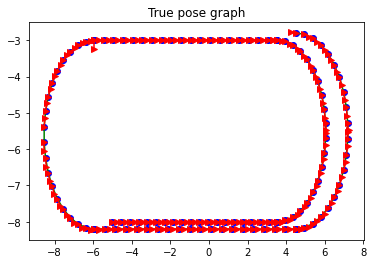

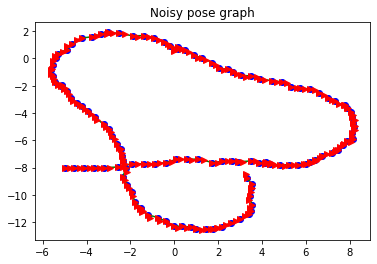

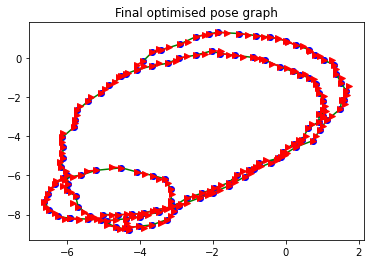

In [27]:
noisy_poses = readVertex("../data/edges-poses.g2o")
edges = readEdge("../data/edges-poses.g2o")
info_mat = compute_info_mat(edges, 50, 100, 1000)
opt_poses = SLAM_2D(noisy_poses, edges, info_mat, 200, 0.01, 1e-3)

write_poses(opt_poses, edges, "../data/50,100,1000", "opt-edges-poses.g2o")

#### Information values (10, 500, 1000)

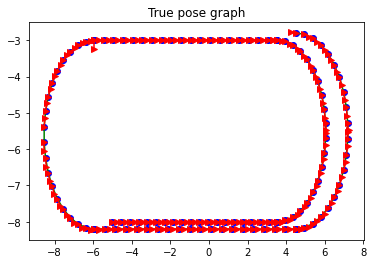

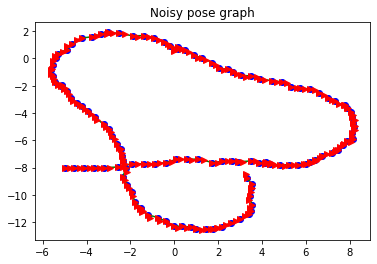

Iteration 1
Time taken by jax to compute jacobian: 3.75505
Time taken to compute jacobian analytically: 2.82597
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 456694.37500

Iteration 2
Time taken by jax to compute jacobian: 4.11235
Time taken to compute jacobian analytically: 3.02340
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 33304.03516

Iteration 3
Time taken by jax to compute jacobian: 3.32881
Time taken to compute jacobian analytically: 2.62485
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 924.99176

Iteration 4
Time taken by jax to compute jacobian: 3.28533
Time taken to compute jacobian analytically: 2.50899
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 517.39368

Iteration 5
Time taken by jax to compute jacobian: 3.26332
Time taken to compute jacobian analytically: 2.45779
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 517.39368



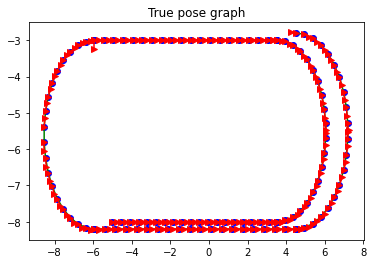

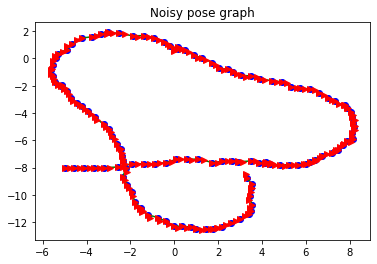

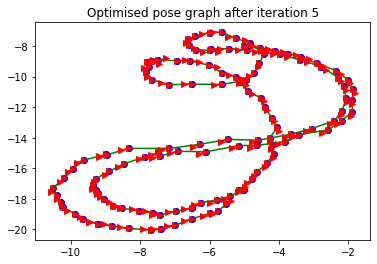

Iteration 6
Time taken by jax to compute jacobian: 3.39520
Time taken to compute jacobian analytically: 2.42988
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 517.39368

Iteration 7
Time taken by jax to compute jacobian: 3.27851
Time taken to compute jacobian analytically: 2.46446
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 212.17484

Iteration 8
Time taken by jax to compute jacobian: 3.26820
Time taken to compute jacobian analytically: 2.49887
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 154.37401

Iteration 9
Time taken by jax to compute jacobian: 3.28865
Time taken to compute jacobian analytically: 2.47632
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 154.37401

Iteration 10
Time taken by jax to compute jacobian: 3.25819
Time taken to compute jacobian analytically: 2.47520
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 137.27414



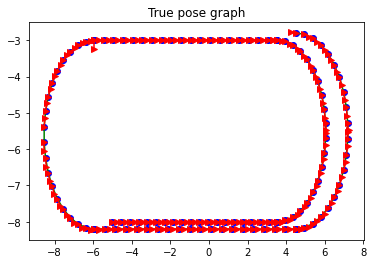

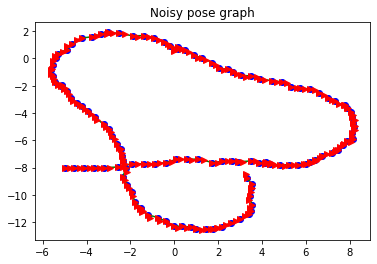

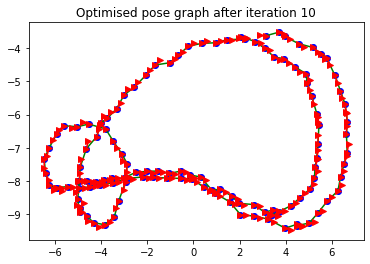

Iteration 11
Time taken by jax to compute jacobian: 3.28999
Time taken to compute jacobian analytically: 2.51442
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 56.71220

Iteration 12
Time taken by jax to compute jacobian: 3.41870
Time taken to compute jacobian analytically: 2.46551
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 25.23662

Iteration 13
Time taken by jax to compute jacobian: 3.44411
Time taken to compute jacobian analytically: 2.45857
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 12.56956

Iteration 14
Time taken by jax to compute jacobian: 3.27552
Time taken to compute jacobian analytically: 2.47397
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 10.36444

Iteration 15
Time taken by jax to compute jacobian: 3.47551
Time taken to compute jacobian analytically: 2.44783
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.80123



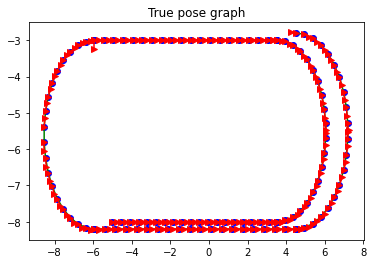

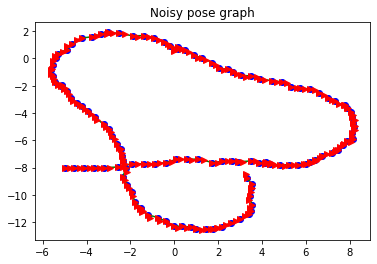

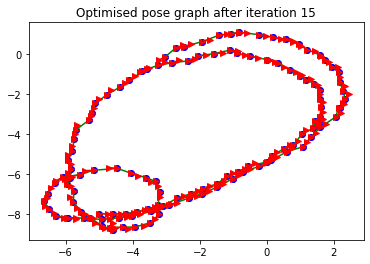

Iteration 16
Time taken by jax to compute jacobian: 3.27683
Time taken to compute jacobian analytically: 2.45436
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.68995

Iteration 17
Time taken by jax to compute jacobian: 3.30549
Time taken to compute jacobian analytically: 2.86714
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.66093

Iteration 18
Time taken by jax to compute jacobian: 3.75786
Time taken to compute jacobian analytically: 2.49908
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.65271

Iteration 19
Time taken by jax to compute jacobian: 3.31546
Time taken to compute jacobian analytically: 2.57858
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64985

Iteration 20
Time taken by jax to compute jacobian: 3.37626
Time taken to compute jacobian analytically: 2.78852
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64874



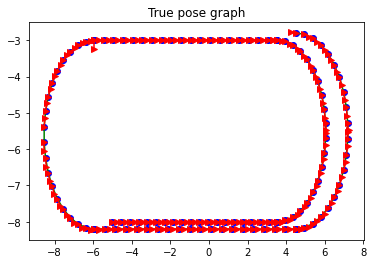

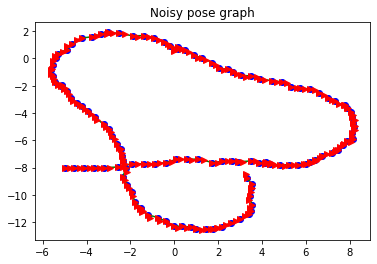

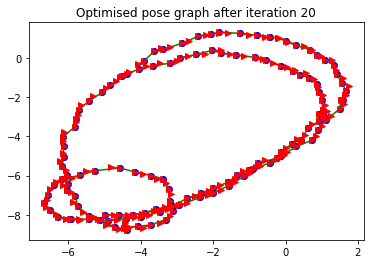

Iteration 21
Time taken by jax to compute jacobian: 3.25035
Time taken to compute jacobian analytically: 2.55214
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64829

Iteration 22
Time taken by jax to compute jacobian: 3.23776
Time taken to compute jacobian analytically: 2.64475
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64809

Iteration 23
Time taken by jax to compute jacobian: 3.99642
Time taken to compute jacobian analytically: 4.72603
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64802

Iteration 24
Time taken by jax to compute jacobian: 3.33562
Time taken to compute jacobian analytically: 2.49851
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64797

Iteration 25
Time taken by jax to compute jacobian: 3.26604
Time taken to compute jacobian analytically: 2.58754
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64796



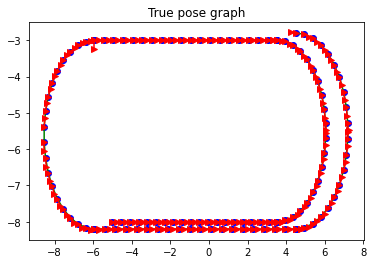

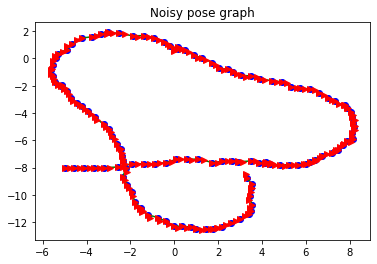

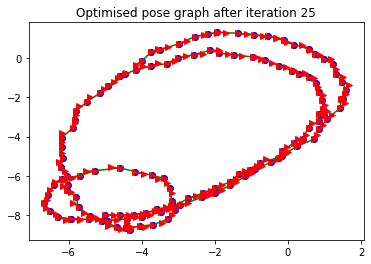

Iteration 26
Time taken by jax to compute jacobian: 3.43910
Time taken to compute jacobian analytically: 2.78875
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64796

Iteration 27
Time taken by jax to compute jacobian: 3.47599
Time taken to compute jacobian analytically: 2.57203
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64795

Iteration 28
Time taken by jax to compute jacobian: 3.35209
Time taken to compute jacobian analytically: 2.67373
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64795

Iteration 29
Time taken by jax to compute jacobian: 3.50609
Time taken to compute jacobian analytically: 2.69066
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 30
Time taken by jax to compute jacobian: 3.49707
Time taken to compute jacobian analytically: 2.61251
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794



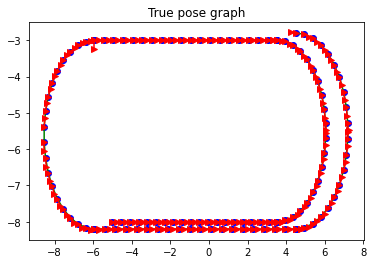

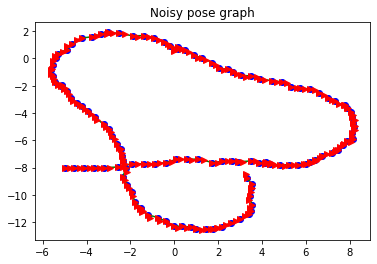

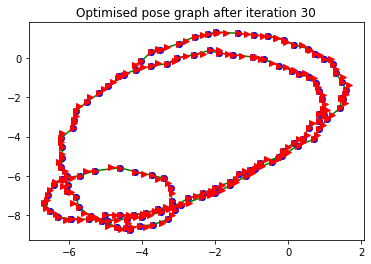

Iteration 31
Time taken by jax to compute jacobian: 3.34762
Time taken to compute jacobian analytically: 3.00322
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 32
Time taken by jax to compute jacobian: 3.23598
Time taken to compute jacobian analytically: 2.50729
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 33
Time taken by jax to compute jacobian: 4.45097
Time taken to compute jacobian analytically: 2.97841
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 34
Time taken by jax to compute jacobian: 3.40303
Time taken to compute jacobian analytically: 2.57475
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 35
Time taken by jax to compute jacobian: 3.53071
Time taken to compute jacobian analytically: 2.48876
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794



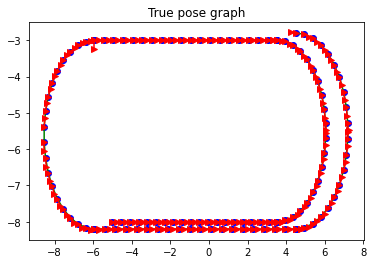

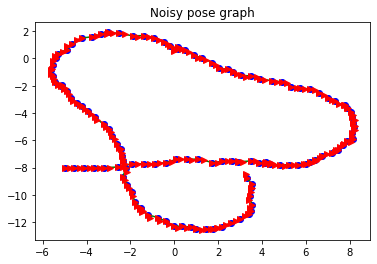

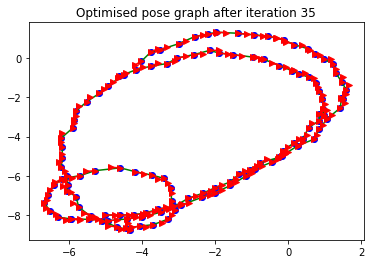

Iteration 36
Time taken by jax to compute jacobian: 3.20998
Time taken to compute jacobian analytically: 2.69703
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 37
Time taken by jax to compute jacobian: 3.20441
Time taken to compute jacobian analytically: 2.44228
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 38
Time taken by jax to compute jacobian: 3.23827
Time taken to compute jacobian analytically: 2.46005
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 39
Time taken by jax to compute jacobian: 3.22787
Time taken to compute jacobian analytically: 2.43245
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 40
Time taken by jax to compute jacobian: 3.20598
Time taken to compute jacobian analytically: 2.44403
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794



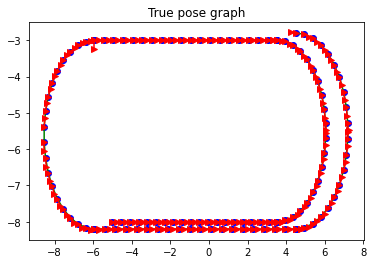

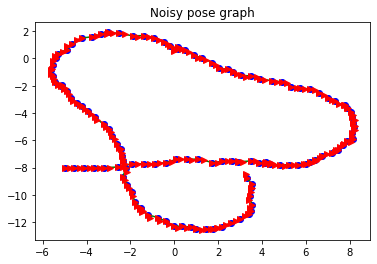

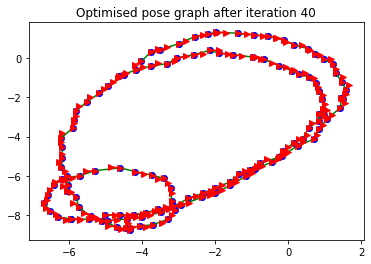

Iteration 41
Time taken by jax to compute jacobian: 3.21534
Time taken to compute jacobian analytically: 2.45300
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 42
Time taken by jax to compute jacobian: 3.97409
Time taken to compute jacobian analytically: 2.61655
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 43
Time taken by jax to compute jacobian: 3.21009
Time taken to compute jacobian analytically: 2.46275
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 44
Time taken by jax to compute jacobian: 3.24640
Time taken to compute jacobian analytically: 2.57267
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 45
Time taken by jax to compute jacobian: 3.29599
Time taken to compute jacobian analytically: 2.48247
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794



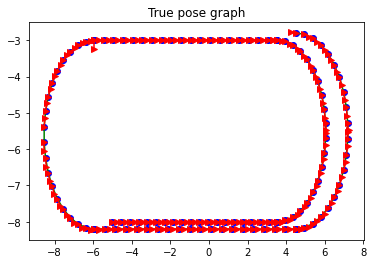

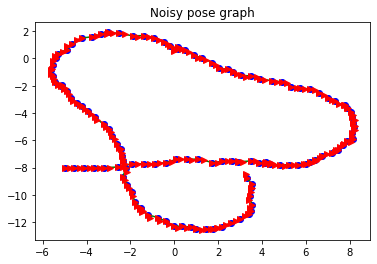

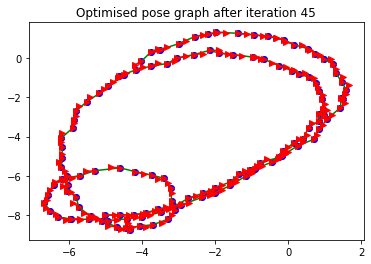

Iteration 46
Time taken by jax to compute jacobian: 3.40494
Time taken to compute jacobian analytically: 2.58004
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 47
Time taken by jax to compute jacobian: 3.27934
Time taken to compute jacobian analytically: 2.99843
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 48
Time taken by jax to compute jacobian: 4.12496
Time taken to compute jacobian analytically: 2.63608
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 49
Time taken by jax to compute jacobian: 3.28260
Time taken to compute jacobian analytically: 2.46951
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 50
Time taken by jax to compute jacobian: 3.44231
Time taken to compute jacobian analytically: 2.53490
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794



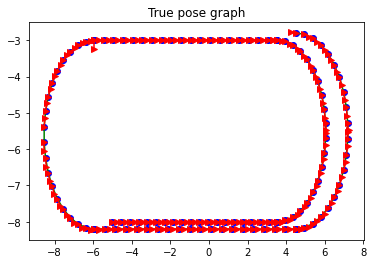

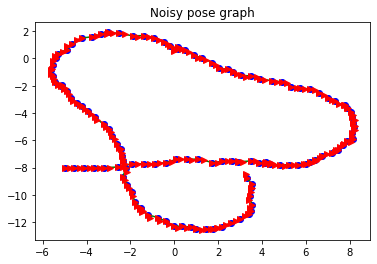

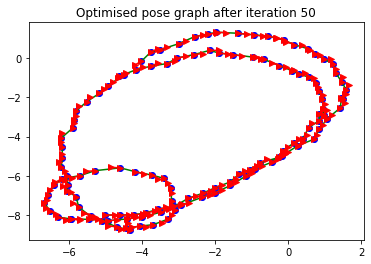

Iteration 51
Time taken by jax to compute jacobian: 3.64529
Time taken to compute jacobian analytically: 3.29890
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 52
Time taken by jax to compute jacobian: 3.42649
Time taken to compute jacobian analytically: 3.20170
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 53
Time taken by jax to compute jacobian: 5.37628
Time taken to compute jacobian analytically: 3.30991
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

Iteration 54
Time taken by jax to compute jacobian: 3.67153
Time taken to compute jacobian analytically: 3.39175
Frobenius norm between jax jacobian and analytical jacobian is: 0.0
Error: 9.64794

SLAM converged at iteration 54


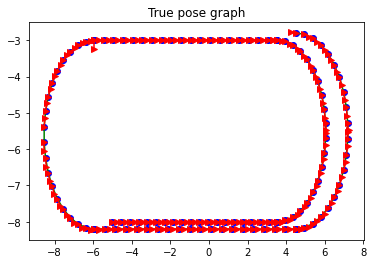

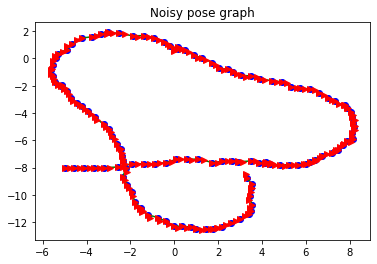

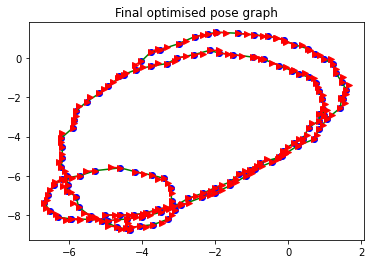

In [28]:
noisy_poses = readVertex("../data/edges-poses.g2o")
edges = readEdge("../data/edges-poses.g2o")
info_mat = compute_info_mat(edges, 10, 500, 1000)
opt_poses = SLAM_2D(noisy_poses, edges, info_mat, 200, 0.01, 1e-3)

write_poses(opt_poses, edges, "../data/10,500,1000", "opt-edges-poses.g2o")

#### Analysis

Lets put the data obtained in the above experiments into a table

|Information matrix values (odometry, loop closure, anchor)|Number of iterations|Final error|
:-------------------------:|:-------------------------:|:----------------:|
500, 700, 1000   | 60 | 444.57599 |
250, 700, 1000   | 67 | 230.08858 |
50, 700, 1000    | 101| 47.82652  |
250, 500, 1000   | 66 | 226.62654 |
50, 500, 1000    | 59 | 47.61123  |
250, 500, 700    | 68 | 226.62648 |
150, 300, 1000   | 73 | 135.97589 |
50, 300, 1000    | 57 | 47.14349  |
100, 300, 500    | 44 | 92.28865  |
50, 100, 1000    | 57 | 45.32530  |
10, 500, 1000    | 54 | 9.64794   |

The experiments are done using wide range of values of information matrix, namely odometry information value, loop closure information value and anchor point information value.

We see that with the initial values of (500, 700, 1000), the algorithm converges in 60 iterations with final error value of 444.57599, which is pretty high. On the other hand, with information values (10, 500, 1000), the algorithm takes 54 iterations to converge, but the final error value is 9.64794. There is a wide gap between these values.

From the table above, we can see that,
* Information value of odometry edge is proportional to final error after convergence. We see that by decreasing the informatino value of odometry edge when keeping other two as constant, the final error value after convergence also decreases. But suprisingly, it is proportional to the information value of odometry edge. For example, in the rows 1 and 2, the loop closure and anchor info values are kept constant and odometry edge info value is reduced from 500 to 250 (half), we see that the error decreased by almost half. Similarly, we can compare many other observations to see this. This basically means that with increasing gap between odometry edge info value and loop closure edge info value, the final error value decreases.

* The decrease in loop clouse edge information value alone doesn't change the error value much. For example, in rows 3 and 10, the odometry edge info value is 50 and anchor info value is 1000. The loop closure edge info value after decreasing from 700 to 100, the error value decrease only by ~2.5. Hence, this shows that odometry edge info values affect the error values more. Similarly, anchor information values too don't affect the error value much. The number of iterations taken to converge is also same. But still, we keep the anchor info value high because we have high confidence in that.

* The trajectories obtained from the above experimentations are all almost similar to each other. The trajectory, even though not near to actual trajectory, comes close to original trajectory in terms of shape (oval). The the loop closure constraints have attached the loose ends of the graph because of high info value given to them.

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

The residuals are basically $ f(pose_k, control_k) - pose_{k+1} $, which say about the correctness of motion model $ f $. There are 119 odometry constraints for 120 poses (number of edges in linear graph with n vertices is n-1), 20 loop closure constraints and 1 anchor point constraint Hence, there are a total of 140 constraints. For each constraint, we apply $ f(pose_k, control_k) - pose_{k+1} $ to get a residual vector of size 3 (for x, y, theta), which is as ($ \Delta_x, \Delta_y, \Delta_{\theta} $) and keep on appending it to main residual vector which will contain this for all edge constraints. Hence, from these 140 constraints, we get a residual of size (420,).

If residual is $ \Delta_{k} = f(pose_k, control_k) - pose_{k+1} $, then 

$ \Delta_k = (\Delta_x, \Delta_y, \Delta_{\theta}) $

$\ \ \ = \bigg( x_k + \Delta x_{(k, k+1)} cos(\theta_k) - \Delta y_{(k, k+1)} sin(\theta_k) - x_{k+1}, y_k + \Delta y_{(k, k+1)} cos(\theta_k) + \Delta x_{(k, k+1)} sin(\theta_k) - y_{k+1}, \theta_k + \Delta \theta_{(k, k+1)} - \theta_{k+1} \bigg) $

Hence, the residual is of the structure,

$ \big( \Delta_{x_{(0,1)}}, \Delta_{y_{(0,1)}}, \Delta_{\theta_{(0,1)}}, \Delta_{x_{(1,2)}}, \Delta_{y_{(1,2)}}, \Delta_{\theta_{(1,2)}}, \Delta_{x_{(2,3)}}, \Delta_{y_{(2,3)}}, \Delta_{\theta_{(2,3)}}, ...... \big) $



Jacobian is a matrix of partial derivates of one vector with respect to another vector. If we need derivate of vector $ a = (a_0, a_1, a_2, .... ) $ with respect to $ b = (b_0, b_1, b_2, ... ) $, then the jacobian will be of the form

$$ J = 
\left( \begin{array}{cc} 
\frac{\delta a_0}{\delta b_0} & \frac{\delta a_0}{\delta b_1} & \frac{\delta a_0}{\delta b_2} & ...\\
\frac{\delta a_1}{\delta b_0} & \frac{\delta a_1}{\delta b_1} & \frac{\delta a_1}{\delta b_2} & ...\\
\frac{\delta a_2}{\delta b_0} & \frac{\delta a_2}{\delta b_1} & \frac{\delta a_2}{\delta b_2} & ...\\
... & ... & ... & ...\\
\end{array} \right)
$$ 

For our project, we have to take derivative of residual vector with respect to pose vector $ \big( x_0, x_1, x_2, ..., y_0, y_1, y_2, ..., \theta_0, \theta_1, \theta_2, ... ) $. The pose is obtained after reshaping the main pose vector which was of the size (3, 120) to (360,) in the row major form. Hence, the pose vector will be of the form given above. Hence the jacobian J will be of the structure,


$$ J = 
\left( \begin{array}{cc} 
\frac{\delta \Delta x_{(0,1)}}{\delta x_0} & \frac{\delta \Delta x_{(0,1)}}{\delta x_1} & ... & \frac{\delta \Delta x_{(0,1)}}{\delta y_0} & \frac{\delta \Delta x_{(0,1)}}{\delta y_1} & ... & \frac{\delta \Delta x_{(0,1)}}{\delta \theta_0} & \frac{\delta \Delta x_{(0,1)}}{\delta \theta_1} & ... \\
\frac{\delta \Delta y_{(0,1)}}{\delta x_0} & \frac{\delta \Delta y_{(0,1)}}{\delta x_1} & ... & \frac{\delta \Delta y_{(0,1)}}{\delta y_0} & \frac{\delta \Delta y_{(0,1)}}{\delta y_1} & ... & \frac{\delta \Delta y_{(0,1)}}{\delta \theta_0} & \frac{\delta \Delta y_{(0,1)}}{\delta \theta_1} & ... \\
\frac{\delta \Delta \theta_{(0,1)}}{\delta x_0} & \frac{\delta \Delta \theta_{(0,1)}}{\delta x_1} & ... & \frac{\delta \Delta \theta_{(0,1)}}{\delta y_0} & \frac{\delta \Delta \theta_{(0,1)}}{\delta y_1} & ... & \frac{\delta \Delta \theta_{(0,1)}}{\delta \theta_0} & \frac{\delta \Delta \theta_{(0,1)}}{\delta \theta_1} & ... \\
\frac{\delta \Delta x_{(1,2)}}{\delta x_0} & \frac{\delta \Delta x_{(1,2)}}{\delta x_1} & ... & \frac{\delta \Delta x_{(1,2)}}{\delta y_0} & \frac{\delta \Delta x_{(1,2)}}{\delta y_1} & ... & \frac{\delta \Delta x_{(1,2)}}{\delta \theta_0} & \frac{\delta \Delta x_{(1,2)}}{\delta \theta_1} & ... \\
\frac{\delta \Delta y_{(1,2)}}{\delta x_0} & \frac{\delta \Delta y_{(1,2)}}{\delta x_1} & ... & \frac{\delta \Delta y_{(1,2)}}{\delta y_0} & \frac{\delta \Delta y_{(1,2)}}{\delta y_1} & ... & \frac{\delta \Delta y_{(1,2)}}{\delta \theta_0} & \frac{\delta \Delta y_{(1,2)}}{\delta \theta_1} & ... \\
\frac{\delta \Delta \theta_{(1,2)}}{\delta x_0} & \frac{\delta \Delta \theta_{(1,2)}}{\delta x_1} & ... & \frac{\delta \Delta \theta_{(1,2)}}{\delta y_0} & \frac{\delta \Delta \theta_{(1,2)}}{\delta y_1} & ... & \frac{\delta \Delta \theta_{(1,2)}}{\delta \theta_0} & \frac{\delta \Delta \theta_{(1,2)}}{\delta \theta_1} & ... \\
... & ... & ... & ... & ... & ... & ... & ... & ...\\
\end{array} \right)
$$ 

Each pose has 3 components $ (x, y, \theta) $. As we have 120 poses and 140 constraints, we get residual vector of size 420 and pose vector of size 360 (after reshaping into linear vector). Hence, the shape of the Jacobian matrix is (420, 360).

We can see that the first one third of cloumns (0-120) are partial derivates of all elements in residual vector wrt $ x_i $, the second one third of the columns (120-240) are partial derivative of all elements in residual vector wrt $ y_i $ and the final one third of the columns (240-360) are partial derivatives of all elements in residual vector.

Jacobian shape: (420, 360)


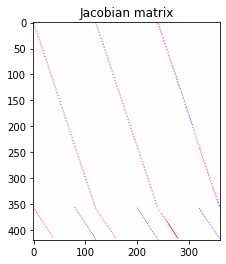

In [29]:
poses = readVertex("../data/edges-poses.g2o")
edges = readEdge("../data/edges-poses.g2o")

J = compute_jacobian(poses.reshape(-1), edges)
print("Jacobian shape:", J.shape)
plt.imshow(J, cmap='seismic')
plt.title("Jacobian matrix")
plt.show()

The jaconbian matrix structure is as shown above. We see that the matrix is divided into equal parts in columns. We see that columns 0-119, 120-239, 240-359 repeat their structures.

Lets consider first one third columns of the matrix. We see that in that sub matrix of the shape (420, 120), we see a diagonal line until row 359. This is for the odometry constraints. As the odometry constraints are dependent only on consecutive 2 poses (vertices), we see that it is a diagonal gradient (line in graph). However, the slope is not 1 (it is 3), because we have residuals of y and theta also in the rows, to which the gradients wrt to x is zero. Hence, there is a discontinuity in the slant line and the slope is 3.

From row 360 to 420, we see two slant lines, one from column 0 to 38 and another from 80 to 118. These are from loop closure constraints. Intuitively we can say that inital one third of poses (vertices) and last one third of poses (vertices) participate in loop closure (evident from groundtruth pose graph). Hence the first 40 and last 40 vertices must have non zero gradients in loop closure constraints. This is the reason we see those two slant gradients in the bootom.

This structure repeats from second and last part (one thirds) of the columns also, which are partial derivatives wrt y and $ \theta $ respectively. However, we can see that the third slant line which denotes the partial derivates of odometry edges with respect to $ \theta_i $ has color changing along the line, which denotes changing values, whereas in the first and second lines (partial derivates of odometry edges wrt $ x_i $ and $ y_i $), the color is constant (two lines present), which denotes constant value (-1 and 1). This is because when we look at the partial derivates wrt $ x_i $ and $ y_i $, the values are either -1 ($ \frac{\delta x_{i+1}}{\delta x_i} $), 0 or 1 ($ \frac{\delta x_i}{\delta x_i} $) only. But the partial derivates wrt $ \theta_i $ will have $ \Delta x_i $, $ \Delta y_i $, $ cos(\theta_i) $ and $ sin(\theta_i) $, which results into different values with changing edges.

The optimization procedure is iterative and incremental. In each iteration, the edges are being optimized as per the given information matrix to estimate the optimal poses in the pose graph. In this optimization process, the values given in the information matrix is important, because these values are the ones which decide the convergence and optimality of the output. The experiments with different values in information matrix (odometry edge information value, loop closure edge information value and anchor information value) is done above and the observations are also jotted down.

Intuitively speaking, the edges act like elastic bands where the elasticity is determined by the information value given for that edge. If the information value is high, it means there is more confidence in that edge and hence the edge is more rigid (less elastic). On the other hand, if the information value given is less, it means the confidence in that edge is less and hence it is more elastic (less rigid). So, the initial pose graph is in unstable state and hence, tries to come to equilibrium state. This process in this algorithm take several iterations in small steps to reach equilibrium. This is the localization part of the SLAM algorithm, where we are trying to optimize the poses if the robot which is prone to noise from LiDAR scans.

From the plots from the experiments (plotting the optimised pose graph every 5 iterations), we can see that first the loop closure edges are getting optimized quickly because we have given higher information value for the loop clousure edges. The rate of convergence of odometry edges is lesser than that of loop clousure edges and anchor. We see that within 5 iterations, the loop closure edges act and come to stable state (the loop closure poses are nearer to each other), where the odometry edges take more time to come to stable state, even though they are not near to the original pose graph. This observatino can be seen in all experiments.

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [30]:
# write_poses(opt_poses, edges, "../data/opt.g2o")